# Supervised Learning - Foundations Project: ReCell

## Problem Statement

### Business Context

Buying and selling used phones and tablets used to be something that happened on a handful of online marketplace sites. But the used and refurbished device market has grown considerably over the past decade, and a new IDC (International Data Corporation) forecast predicts that the used phone market would be worth \\$52.7bn by 2023 with a compound annual growth rate (CAGR) of 13.6% from 2018 to 2023. This growth can be attributed to an uptick in demand for used phones and tablets that offer considerable savings compared with new models.

Refurbished and used devices continue to provide cost-effective alternatives to both consumers and businesses that are looking to save money when purchasing one. There are plenty of other benefits associated with the used device market. Used and refurbished devices can be sold with warranties and can also be insured with proof of purchase. Third-party vendors/platforms, such as Verizon, Amazon, etc., provide attractive offers to customers for refurbished devices. Maximizing the longevity of devices through second-hand trade also reduces their environmental impact and helps in recycling and reducing waste. The impact of the COVID-19 outbreak may further boost this segment as consumers cut back on discretionary spending and buy phones and tablets only for immediate needs.


### Objective

The rising potential of this comparatively under-the-radar market fuels the need for an ML-based solution to develop a dynamic pricing strategy for used and refurbished devices. ReCell, a startup aiming to tap the potential in this market, has hired you as a data scientist. They want you to analyze the data provided and build a linear regression model to predict the price of a used phone/tablet and identify factors that significantly influence it.


### Data Description

The data contains the different attributes of used/refurbished phones and tablets. The data was collected in the year 2021. The detailed data dictionary is given below.


- brand_name: Name of manufacturing brand
- os: OS on which the device runs
- screen_size: Size of the screen in cm
- 4g: Whether 4G is available or not
- 5g: Whether 5G is available or not
- main_camera_mp: Resolution of the rear camera in megapixels
- selfie_camera_mp: Resolution of the front camera in megapixels
- int_memory: Amount of internal memory (ROM) in GB
- ram: Amount of RAM in GB
- battery: Energy capacity of the device battery in mAh
- weight: Weight of the device in grams
- release_year: Year when the device model was released
- days_used: Number of days the used/refurbished device has been used
- normalized_new_price: Normalized price of a new device of the same model in euros
- normalized_used_price: Normalized price of the used/refurbished device in euros

## Importing necessary libraries

In [89]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
import datetime as dt

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# split the data into train and test
from sklearn.model_selection import train_test_split

# to build linear regression_model
import statsmodels.api as sm

# to check model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# to compute VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# to check normalcy
import pylab
import scipy.stats as stats

# to check homoscedasticity
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

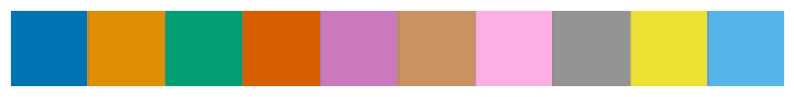

In [2]:
# Set standard styling; writer has slight vision deficiency
# Paper context selected for readability in turned in .html format, but was originally written in noteebook context
custom_palette = sns.color_palette('colorblind')
sns.set(style='whitegrid', context='paper', palette= custom_palette)
sns.set(rc={'grid.color': 'gray', 'grid.alpha': 0.5})
sns.palplot(custom_palette)

## Loading the dataset

In [3]:
from google.colab import files
import io

try:
    uploaded
except NameError:
    uploaded = files.upload()

df= pd.read_csv(io.BytesIO(uploaded['used_device_data.csv']))

Saving used_device_data.csv to used_device_data.csv


In [6]:
##convert to html snippet
#%%shell
#jupyter nbconvert --to html ///content/SupervisedLearning_ReCell.ipynb

## Data Overview

### Shape

In [7]:
# check the shape of the data
df.shape

(3454, 15)

In [8]:
df.duplicated().sum()

0

There are 3454 rows of data, with 15 starting columns. There are no duplicate rows, so for now that will reamin our shape!

### First few rows and data types

In [9]:
# check the first 5 rows of the data
df.head()

,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,Honor,Android,14.50,yes,no,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,Honor,Android,16.69,yes,yes,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,Honor,Android,25.50,yes,yes,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,Honor,Android,15.32,yes,no,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837


In [10]:
# check column types and number of values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3454 entries, 0 to 3453
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   brand_name             3454 non-null   object 
 1   os                     3454 non-null   object 
 2   screen_size            3454 non-null   float64
 3   4g                     3454 non-null   object 
 4   5g                     3454 non-null   object 
 5   main_camera_mp         3275 non-null   float64
 6   selfie_camera_mp       3452 non-null   float64
 7   int_memory             3450 non-null   float64
 8   ram                    3450 non-null   float64
 9   battery                3448 non-null   float64
 10  weight                 3447 non-null   float64
 11  release_year           3454 non-null   int64  
 12  days_used              3454 non-null   int64  
 13  normalized_used_price  3454 non-null   float64
 14  normalized_new_price   3454 non-null   float64
dtypes: f

*   All data types are as expected
*   There are some missing values that will need treatment
*   The 4g and 5g columns appear to be yes/no objects, but can check the unique values during EDA
*   At this time, all columns appear relavent and worth including in the initial model.
* Release year is a numeric value - but the feature that is more intuitive is how many years ago it was released. Lets go ahead and update that feature.



### Early feature engineering - years_since_release

In [11]:
# Early Feature Engineering - release_year to years_since_release

# create a copy of data so that any edits from here will not change the original uploaded data set
df1 = df.copy()

# To make more robust, defining a current year variable instead of hard coding "2023"
current_year = dt.datetime.now().year

# create new feature
df1['years_since_release'] = current_year - df1['release_year']

# remove old feture
df1.drop(columns=['release_year'], inplace = True)

# rearrange column order. This is purely convenience -
# it puts the used price on the bottom of some later key visualizations for less scrolling.
column_order_temp = list(df1.columns)
column_order_temp[12], column_order_temp[14] = column_order_temp[14], column_order_temp[12]
df1 = df1[column_order_temp]

# check new dataframe info
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3454 entries, 0 to 3453
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   brand_name             3454 non-null   object 
 1   os                     3454 non-null   object 
 2   screen_size            3454 non-null   float64
 3   4g                     3454 non-null   object 
 4   5g                     3454 non-null   object 
 5   main_camera_mp         3275 non-null   float64
 6   selfie_camera_mp       3452 non-null   float64
 7   int_memory             3450 non-null   float64
 8   ram                    3450 non-null   float64
 9   battery                3448 non-null   float64
 10  weight                 3447 non-null   float64
 11  days_used              3454 non-null   int64  
 12  years_since_release    3454 non-null   int64  
 13  normalized_new_price   3454 non-null   float64
 14  normalized_used_price  3454 non-null   float64
dtypes: f

In [12]:
# check the first 5 rows of the new dataframe
df1.head()

,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,days_used,years_since_release,normalized_new_price,normalized_used_price
0,Honor,Android,14.50,yes,no,13.0,5.0,64.0,3.0,3020.0,146.0,127,4,4.715100,4.307572
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,325,4,5.519018,5.162097
2,Honor,Android,16.69,yes,yes,13.0,8.0,128.0,8.0,4200.0,213.0,162,4,5.884631,5.111084
3,Honor,Android,25.50,yes,yes,13.0,8.0,64.0,6.0,7250.0,480.0,345,4,5.630961,5.135387
4,Honor,Android,15.32,yes,no,13.0,8.0,64.0,3.0,5000.0,185.0,293,4,4.947837,4.389995


### Basic Statistical Summary

In [13]:
df1.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
brand_name,3454,34,Others,502,NaN,NaN,NaN,NaN,NaN,NaN,NaN
os,3454,4,Android,3214,NaN,NaN,NaN,NaN,NaN,NaN,NaN
screen_size,3454.0,NaN,NaN,NaN,13.713115,3.80528,5.08,12.7,12.83,15.34,30.71
4g,3454,2,yes,2335,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5g,3454,2,no,3302,NaN,NaN,NaN,NaN,NaN,NaN,NaN
main_camera_mp,3275.0,NaN,NaN,NaN,9.460208,4.815461,0.08,5.0,8.0,13.0,48.0
selfie_camera_mp,3452.0,NaN,NaN,NaN,6.554229,6.970372,0.0,2.0,5.0,8.0,32.0
int_memory,3450.0,NaN,NaN,NaN,54.573099,84.972371,0.01,16.0,32.0,64.0,1024.0
ram,3450.0,NaN,NaN,NaN,4.036122,1.365105,0.02,4.0,4.0,4.0,12.0
battery,3448.0,NaN,NaN,NaN,3133.402697,1299.682844,500.0,2100.0,3000.0,4000.0,9720.0


*   No extraoridnay values in this chart
*   The normalized columns do appear to be normally distributed, while most other have a shift.
*   The phones that have near 0GB of RAM, near 0BG of ROM, and near 0MP on the two main cameras may be outliers. However, the phones do go back to 2013.

### First look at missing values

In [14]:
df1.isnull().sum()

brand_name                 0
os                         0
screen_size                0
4g                         0
5g                         0
main_camera_mp           179
selfie_camera_mp           2
int_memory                 4
ram                        4
battery                    6
weight                     7
days_used                  0
years_since_release        0
normalized_new_price       0
normalized_used_price      0
dtype: int64

Observation:

This initial look shows that:

* One variable, main_camera_mp is missing in 179 of the 3454 data points.
* There are several variables with only a handful of missing values: selfie_camera_mp, int_memory, ram, battery, weight.
* Will come back to these after EDA - we will impute, remove, or otherwise treat based on EDA discoveries.

## Exploratory Data Analysis (EDA)

### Custom Functions for EDA / Visualization

In [15]:
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """

    # creating the 2 subplots
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75), "hspace": 0.05, "top": 0.95},
        figsize=figsize,
    )

    #create a title
    f2.suptitle("Histogram and Boxplot for " + feature, fontsize=16)

    # boxplot will be created and a square will indicate the mean value of the column
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True,
        meanprops={"marker":"s", "markersize" : 8, "markerfacecolor": custom_palette[1], "markeredgecolor":"black"},
        medianprops = {'linewidth':4},
        color = custom_palette[2]
    )

    #remove duplicate x label
    ax_box2.set_xlabel("")

    #create histogram, with consideration of bins
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, alpha = 0.7
    ) if bins is not None else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, alpha = 0.7
    )

    # add mean and median to histogram
    ax_hist2.axvline(
        data[feature].mean(), color = 'black', linestyle= '-', linewidth = 8
    ) # a pseudo border for the mean line

    ax_hist2.axvline(
        data[feature].mean(), color = custom_palette[1], linestyle= '-', linewidth = 5 , label = "Mean"
    )

    ax_hist2.axvline(
        data[feature].median(), color = 'black', linestyle= '-', linewidth = 5, label = "Median"
    )

    # Add a legend
    ax_hist2.legend(loc='upper right')

### Targeted EDA Questions


##### 1. What does the distribution of normalized used device prices look like?

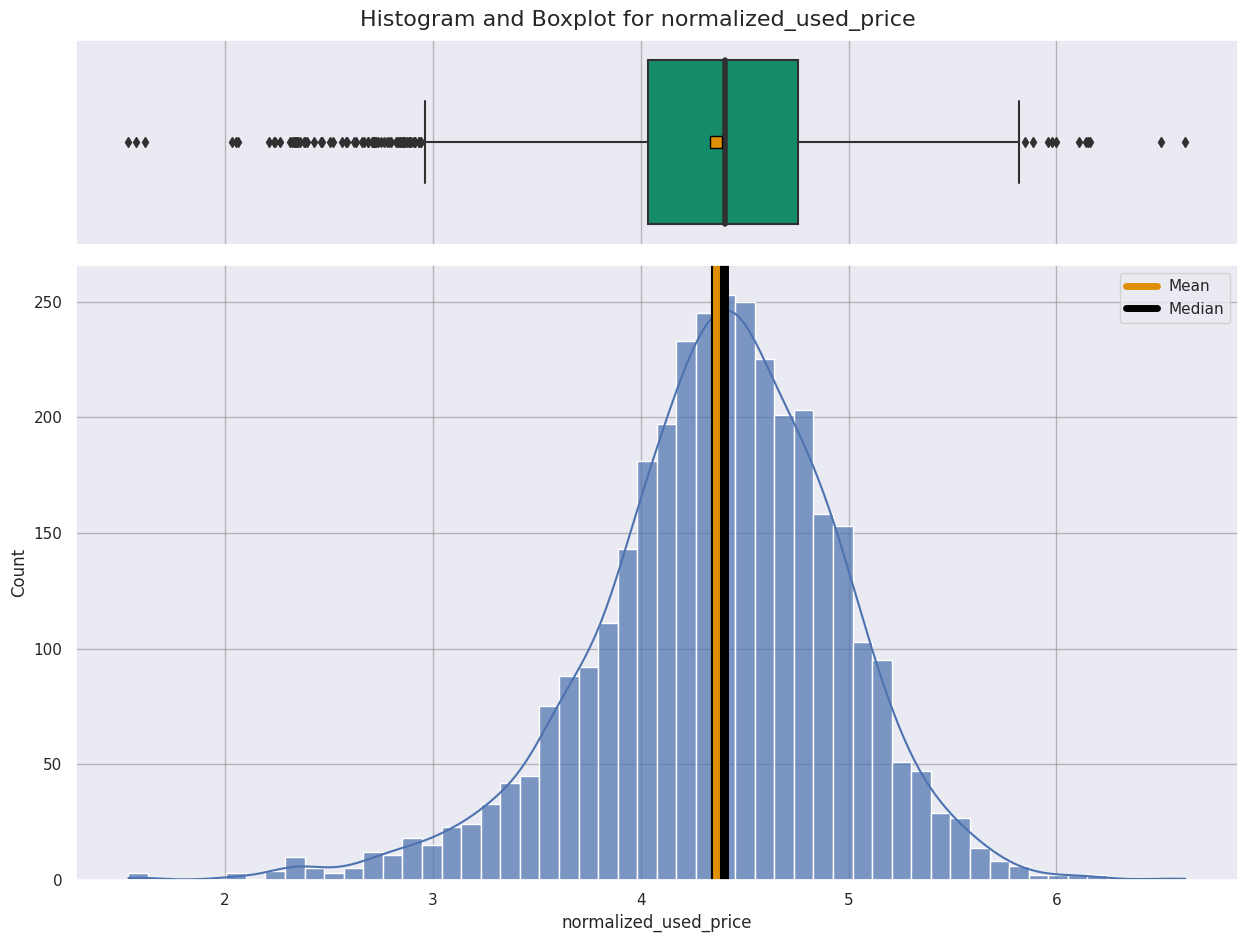

In [16]:
### histogram and boxplot showing target variable - used prices
histogram_boxplot(df1, "normalized_used_price", kde = True)

The used prices are normalized, as the name of the variable implies. The Mean, Median, and Mode are all around the same value of ~4.4. There are many outliers less than the Q1 value, with values between 1.53 and 4.03. The middle 50% of the data is in a very narrow space relative to the actual range of the data.

##### 2. What percentage of the used device market is dominated by Android devices?

In [17]:
df1['os'].value_counts(1)

Android    0.930515
Others     0.039664
Windows    0.019398
iOS        0.010423
Name: os, dtype: float64

Android is 93% of the Market. Which is suprising to me as an Android user myself - the emote reactions between iOS and Android at time of writing still dont work perfectly and generate duplicate messages. This tells me not to trust my own intuition about this market data - I am not a SME and my experience is not standard.

##### 3. The amount of RAM is important for the smooth functioning of a device. How does the amount of RAM vary with the brand?

In [18]:
# Look at the stats summary of the RAM grouped by Brand Name first, then we can visualize a few ways
mean_ram_by_brand = df1.groupby(by = ['brand_name'])['ram'].mean().sort_values()
print(mean_ram_by_brand.describe(), end='\n\n')
print(mean_ram_by_brand)

count    34.000000
mean      3.962049
std       0.787467
min       1.613636
25%       3.790803
50%       4.000000
75%       4.198341
max       6.363636
Name: ram, dtype: float64

brand_name
Celkon        1.613636
Nokia         2.420294
Infinix       2.600000
Lava          3.277778
Karbonn       3.353448
Alcatel       3.407025
Micromax      3.679487
Spice         3.750000
Others        3.777888
BlackBerry    3.829545
Lenovo        3.885965
Acer          3.901961
Gionee        3.933036
LG            3.936567
Motorola      3.943396
Coolpad       3.954545
HTC           4.000000
Panasonic     4.000000
Apple         4.000000
XOLO          4.000000
Microsoft     4.000000
ZTE           4.023214
Asus          4.049180
Sony          4.069767
Realme        4.195122
Samsung       4.199413
Meizu         4.451613
Google        4.533333
Xiaomi        4.583333
Honor         4.603448
Huawei        4.655378
Vivo          4.756410
Oppo          4.961240
OnePlus       6.363636
Name: ram, dtype: float64


* There are 34 brands in this data set, with a mean RAM of 3.96 and a range of 4.75.
* This means the devices with the highest RAM have almost 4 times as much RAM as the devices with the least RAM.
* The standard deviation of 0.78 and the closeness of the mean and Q2 value propose the distribution of average RAMs is somewhat normally distributed, lets take a look.

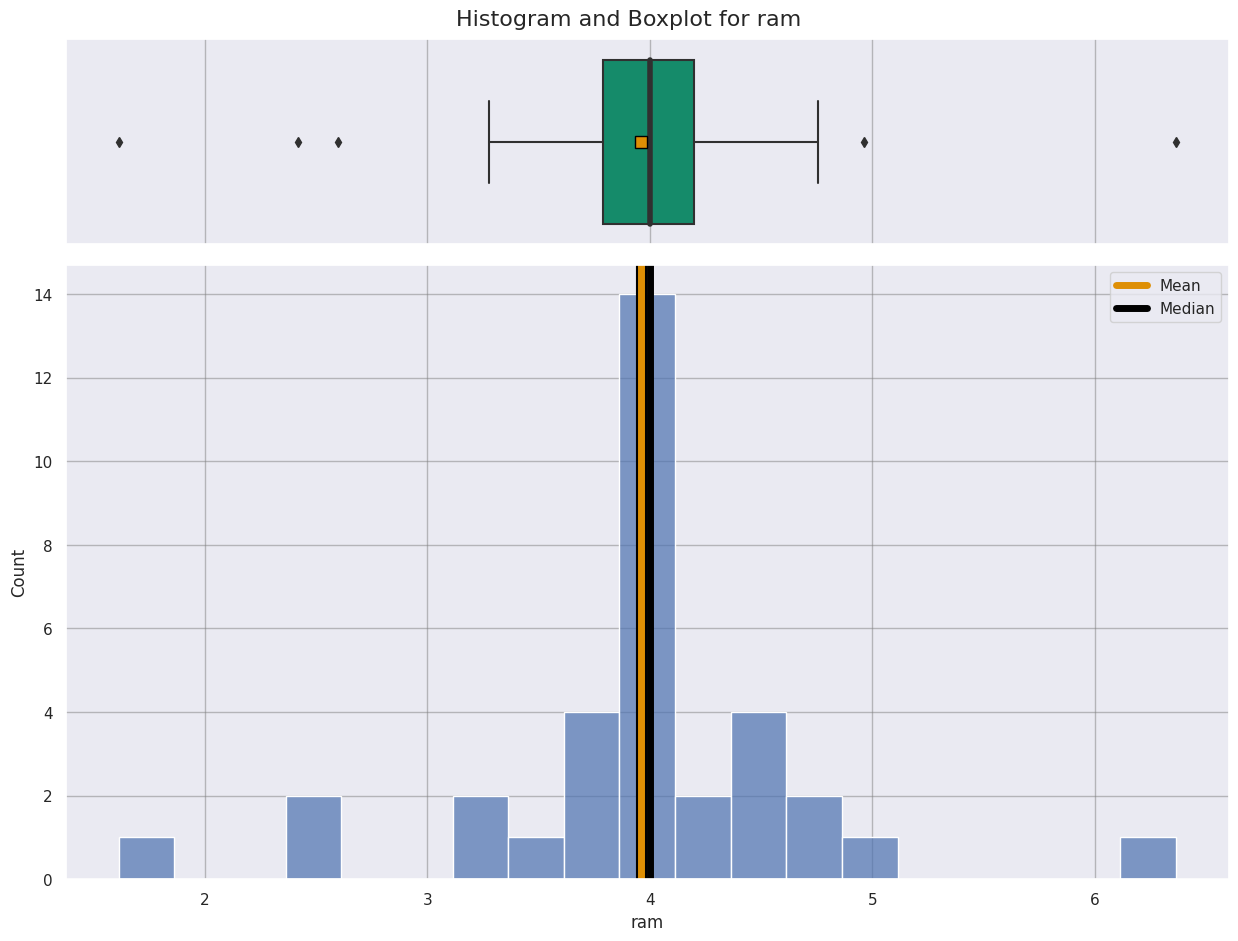

In [19]:
### histogram and boxplot to show distribution of average RAMs across all brands
mean_ram_df = mean_ram_by_brand.reset_index()
histogram_boxplot(mean_ram_df, 'ram')

I would certainly want to ask the SME at this point for guidance on how to treat these outliers. The OnePlus devices with a mean of 6.36 are so far ahead of the group - possibly a niche company? Same with the bottom three brands; Celkon, Nokia, and Infinix. I said earlier that I didnt want to trust my experience with devices, but it is an Internet joke that Nokia devices live forever. I wonder if these three brands also have an older mean age.

In [20]:
# Quick look at years since release by brand
mean_year_by_brand = df1.groupby(by = ['brand_name'])['years_since_release'].mean().sort_values(ascending = False).round(0)
print(mean_year_by_brand)

brand_name
Spice         11.0
Celkon        11.0
Karbonn       11.0
XOLO          10.0
Micromax      10.0
Acer          10.0
Lava           9.0
Microsoft      9.0
Gionee         9.0
Alcatel        9.0
Others         9.0
HTC            9.0
BlackBerry     9.0
Sony           9.0
Asus           9.0
Panasonic      8.0
Lenovo         8.0
Samsung        8.0
ZTE            8.0
LG             8.0
Coolpad        8.0
Nokia          8.0
Apple          7.0
Huawei         7.0
Meizu          7.0
Motorola       7.0
Oppo           7.0
Xiaomi         6.0
Vivo           6.0
Google         6.0
OnePlus        6.0
Honor          6.0
Realme         5.0
Infinix        4.0
Name: years_since_release, dtype: float64


* Reaffirming that my intution/lived experience with cell phones is not helpful here.
* The Infinix brand has the most average releases, Nokia is in the middle and Celkon are the oldest.
* Thus the three Brands with average RAMs below the average are not because of the age of those devices.
* Lets looks a a box plot with the brand names next

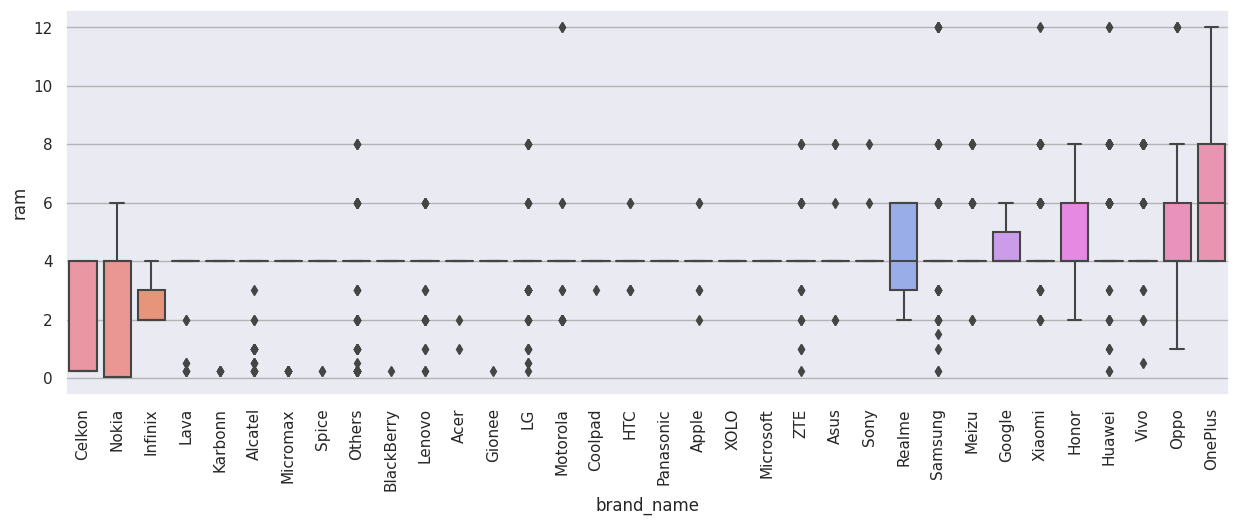

In [21]:
# Box plots show the outliers by brand the best
# Brands are sorted from lowest mean RAM to highest mean RAM
plt.figure(figsize=(15, 5))
sns.boxplot(df1, x="brand_name", y="ram", order=mean_ram_by_brand.index)
plt.xticks(rotation=90)
plt.show()

* The brand-mean and brand-median are both ~ 4 GB of RAM.

* This visualization suggests that brand behavior of device production with respect to RAM is highly variable. The number of outliers and collapsed boxes suggests that most brands intentionally produce a high variety of devices.

* The exceptions to this are the companies who tend to produce devices with similar RAM profiles. These are easily spotted by the size of their tails or presence of no outliers.
 * Celkon, Nokia, and Infinix focus on devices with less than brand-average RAM
 * Realme, Google, Honor all have a window of RAM near the brand-mean and no outliers.
 * OnePlus makes stunnigly above-average RAM devices.

##### 4. A large battery often increases a device's weight, making it feel uncomfortable in the hands. How does the weight vary for phones and tablets offering large batteries (more than 4500 mAh)?

In [22]:
#new dataframe
df_big_batteries = df1[df1['battery'] > 4500]
df_big_batteries['weight'].describe()

count    341.000000
mean     332.275660
std      155.501832
min      118.000000
25%      198.000000
50%      300.000000
75%      467.000000
max      855.000000
Name: weight, dtype: float64

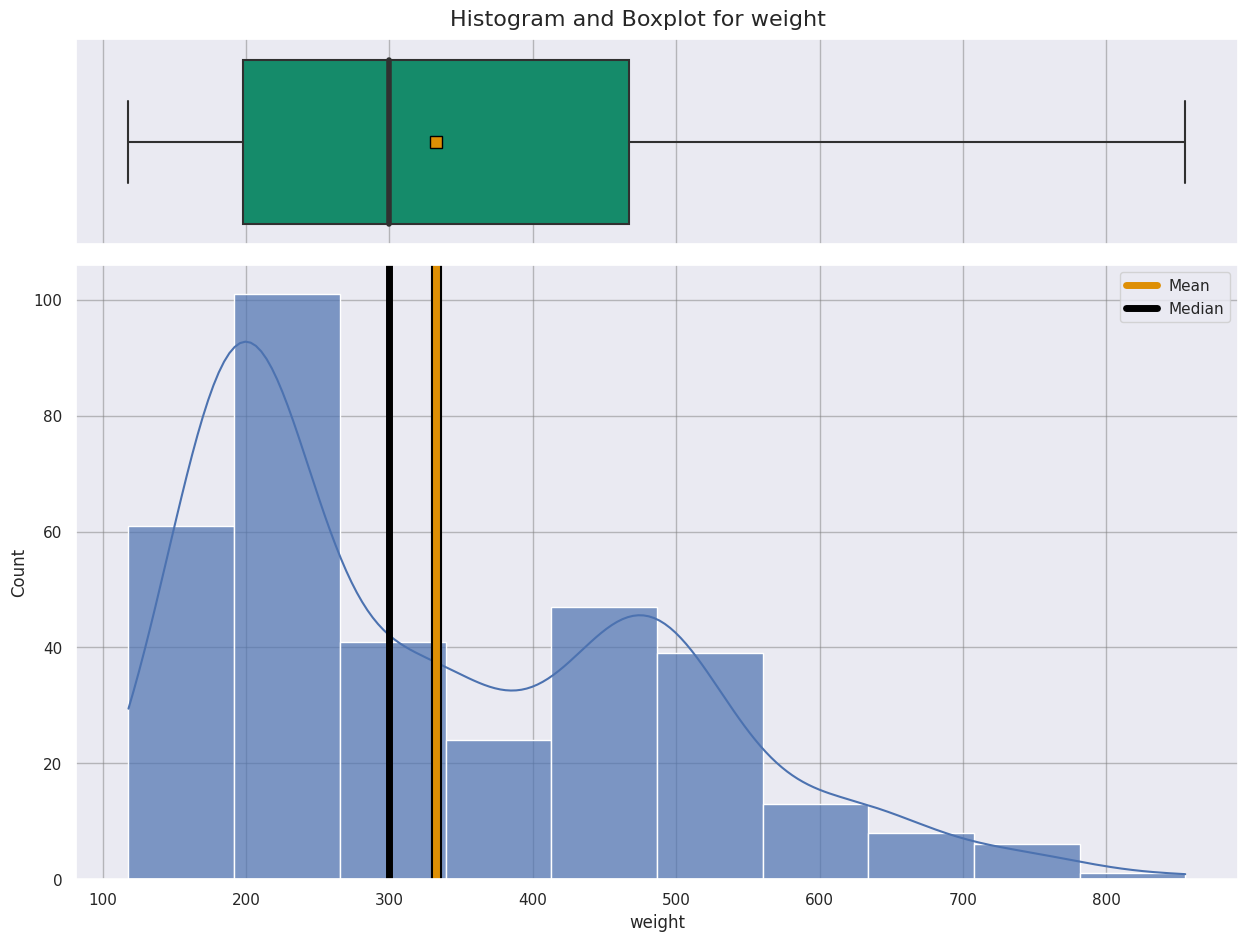

In [23]:
histogram_boxplot(df_big_batteries, 'weight', kde = True)

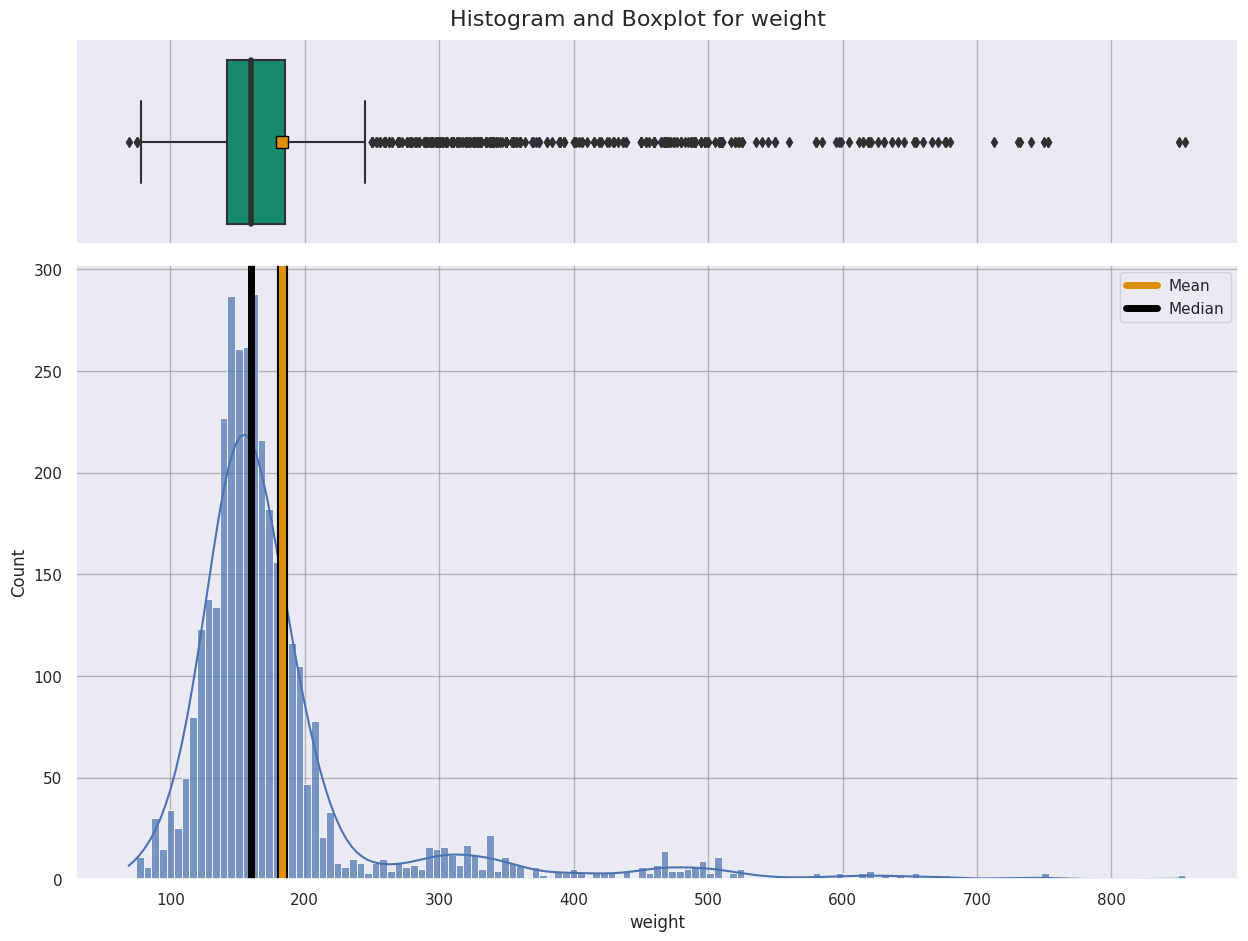

In [24]:
histogram_boxplot(df1, 'weight', kde = True)

These two graphs compare the distribution of ALL device weights, and the distribution of devices weights whose batteries are greater than 4500.

What we see here is that the mode and general shapes of the distributions stay the same - but shited to the right. These large battery devices make up the just right of the curve data of the original distribution. The general shape of this distribution of the big_battery phones is the same; long right tail with a somehwat significant multi-modal distribution, and a mean greater than the median. The big_battery devices are more cetnralized, thus have less identfied outliers. Though they are the outliers of the orginial data set.

##### 5. Bigger screens are desirable for entertainment purposes as they offer a better viewing experience. How many phones and tablets are available across different brands with a screen size larger than 6 inches?

In [25]:
# new datafrome;
df_screen_inches = df1.copy()

# Convert screen size from cm to inches (1 cm = 0.393701 inches)
df_screen_inches['screen_size'] = df1['screen_size'] * 0.393701

#count
df_screen_inches[df_screen_inches['screen_size'] > 6]['brand_name'].value_counts()

Huawei       157
Samsung      131
Others       118
Vivo          82
Oppo          78
Lenovo        76
Honor         72
Xiaomi        69
LG            63
Asus          51
Motorola      43
Realme        41
Alcatel       34
ZTE           25
Apple         24
Sony          23
Meizu         21
Acer          20
Nokia         19
OnePlus       16
HTC           14
Micromax      11
Infinix       10
Gionee         8
Google         7
XOLO           4
Panasonic      3
Coolpad        3
Karbonn        2
Spice          2
Microsoft      1
Name: brand_name, dtype: int64

##### 6. A lot of devices nowadays offer great selfie cameras, allowing us to capture our favorite moments with loved ones. What is the distribution of devices offering greater than 8MP selfie cameras across brands?

In [26]:
#start with the counts
selfie_devices_counts = df1[df1['selfie_camera_mp'] >8]['brand_name'].value_counts()
selfie_devices_counts

Huawei        87
Vivo          78
Oppo          75
Xiaomi        63
Samsung       57
Honor         41
Others        34
LG            32
Motorola      26
Meizu         24
HTC           20
ZTE           20
Realme        18
OnePlus       18
Lenovo        14
Sony          14
Nokia         10
Asus           6
Infinix        4
Gionee         4
Coolpad        3
BlackBerry     2
Micromax       2
Panasonic      2
Acer           1
Name: brand_name, dtype: int64

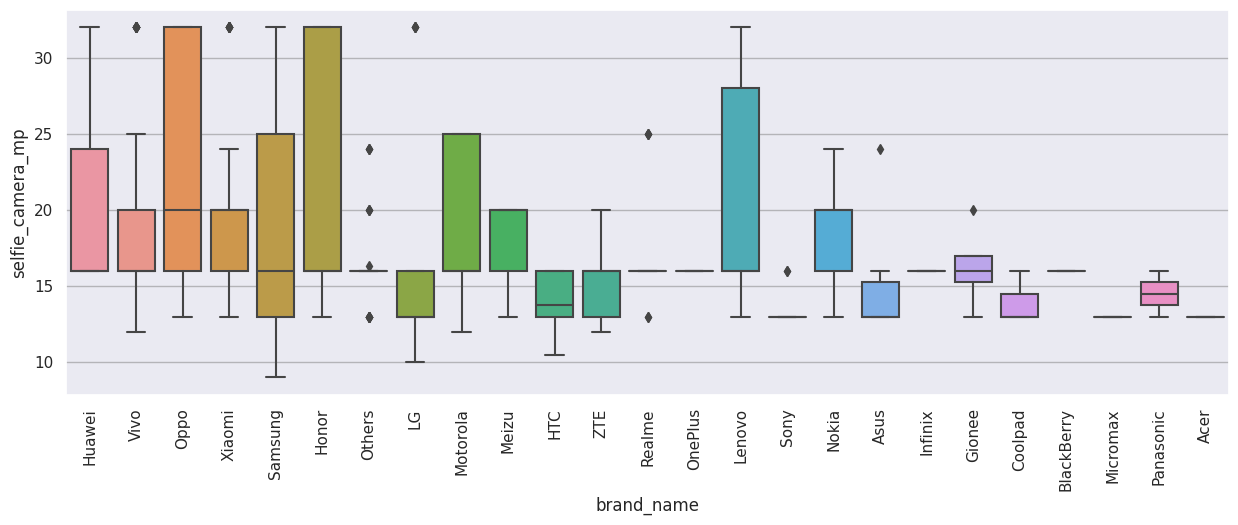

In [27]:
# Box plot here, sorted by count of devices with 8mp+ selfie cameras
plt.figure(figsize=(15, 5))
sns.boxplot(df1[df1['selfie_camera_mp'] >8], x="brand_name", y="selfie_camera_mp", order = selfie_devices_counts.index)
plt.xticks(rotation=90)
plt.show()

##### 7. Which attributes are highly correlated with the normalized price of a used device?

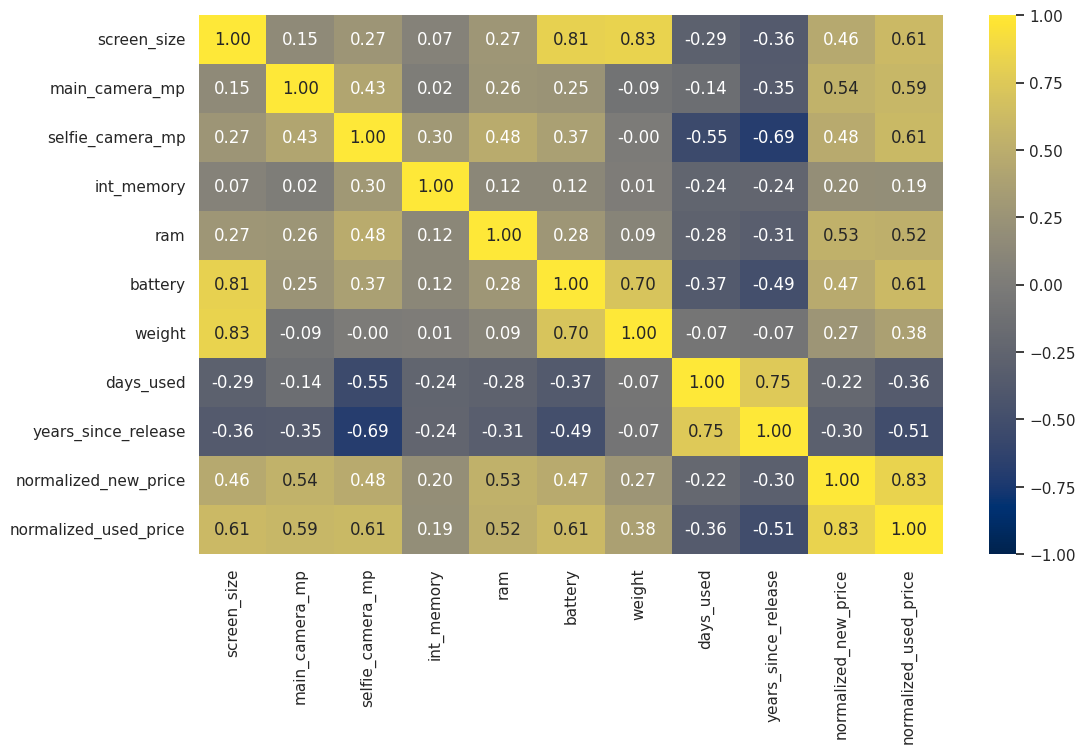

In [28]:
#list of numerical colums
num_cols = df1.select_dtypes(include = np.number).columns.tolist()

#heatmap to show correlations
plt.figure(figsize = (12,7))
sns.heatmap(df1[num_cols].corr(), annot = True, vmin = -1, vmax = 1, fmt=".2f", cmap="cividis")
plt.show()

* `used_price` has positive correlations with the following features, in increasing level of correlation:
  * RAM (0.52)
  * Main camera mp (0.59)
  * Screen size, Selfie camera mp, and Battery (0.61)
  * New price (0.83)
* And it has negative correlations with the following featrues, in increasing level of correlation:
 * days_used (-0.36)
 * years_since_release (-0.51)

### Non-Question Based EDA

Below is a small collection of EDA that is either specifically referenced later or was instrumental in my understanding for model building. Additional EDA can be found here for reference as needed: <a href = #link1>appendix section</a>.

In [29]:
#Are there any observations in the categorical data that are functionally representing missing values?
#Create dataframe of just objects columns
df1_objs = df1.select_dtypes(exclude=['int', 'float'])
#Print each unique observation in every category, with the percent of the category it represents
for col in df1_objs.columns:
  cat_percents = df1_objs[col].value_counts(normalize = True) *100
  print(cat_percents, "\n")


Others        14.533874
Samsung        9.872611
Huawei         7.266937
LG             5.819340
Lenovo         4.950782
ZTE            4.053272
Xiaomi         3.821656
Oppo           3.734800
Asus           3.532137
Alcatel        3.503185
Micromax       3.387377
Vivo           3.387377
Honor          3.358425
HTC            3.184713
Nokia          3.068906
Motorola       3.068906
Sony           2.489867
Meizu          1.795020
Gionee         1.621309
Acer           1.476549
XOLO           1.418645
Panasonic      1.360741
Realme         1.187030
Apple          1.129126
Lava           1.042270
Celkon         0.955414
Spice          0.868558
Karbonn        0.839606
Coolpad        0.636943
BlackBerry     0.636943
Microsoft      0.636943
OnePlus        0.636943
Google         0.434279
Infinix        0.289519
Name: brand_name, dtype: float64 

Android    93.051534
Others      3.966416
Windows     1.939780
iOS         1.042270
Name: os, dtype: float64 

yes    67.602779
no     32.397221
Name

* There are a lot `brands` in this data set, which will make a lot of dummy variables. The question set above showed that `brand` behaviors do result in different performances in the numerical variables, so the brand names will stay for now.
  * `Others` is the largest brand category, reprsenting 14.5% of the total data
  * Followed by Samsung, Huawei, and LG each individually above 5% of the total data
  * There are 9 brands that each are less than 1% of the total data. However, what this data set doesnt really include is the volume or inventory by brand. Just because, for example, Google only has their Pixel line of 15-18 phones, doesnt necessarily mean they represent less than 1% of the used device sales.
* The `os`, `4g`, and `5g` categorical variables all have reasonable values.
  * The top operating system is Android by far - with 93% of the dataset
  * ~67% of the phones have 4g connectivity
  * While only 4.4% of phones have 5g connectivity. The last phones in the data set are 3 years old as of writing, so this particular categorical variable will likely catch up with 4g when the data catches up with 2023 and beyond.

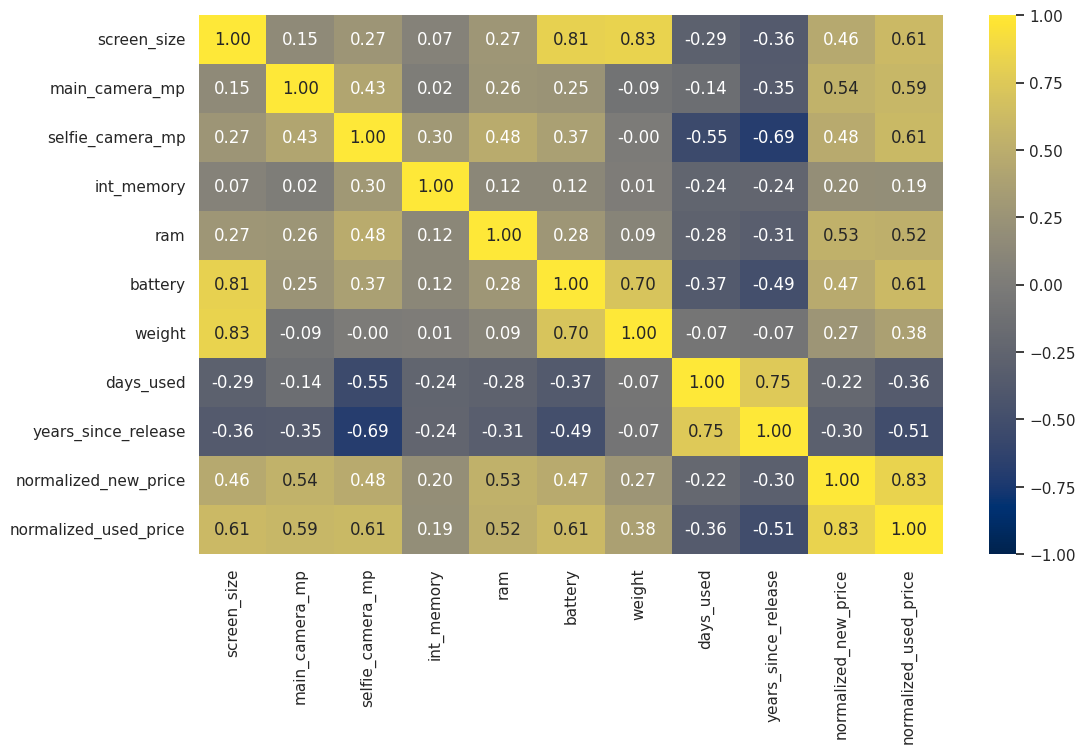

In [30]:
#list of numerical colums
num_cols = df1.select_dtypes(include = np.number).columns.tolist()

#heatmap to show correlations
plt.figure(figsize = (12,7))
sns.heatmap(df1[num_cols].corr(), annot = True, vmin = -1, vmax = 1, fmt=".2f", cmap="cividis")
plt.show()

* `used_price` has positive correlations with the following features, in increasing level of correlation:
  * RAM (0.52)
  * Main camera mp (0.59)
  * Screen size, Selfie camera mp, and Battery (0.61)
  * New price (0.83)

* `screen_size`, `battery`, and `weight` form a trio, likely indicating that larger screen sizes tend to require more battery power and increased battery capacity tends to increase device weight.

* The positive correlation between `days_used` and `years_since_release` is to be expected. As the number of years since a device's release increases, the number of days it has been used also tends to increase.

* `selfie_camera_mp` and `years_since_release` exhibit a high negative correlation. This suggests that selfie cameras have improved the most rapidly of all the features in the last 10 years.

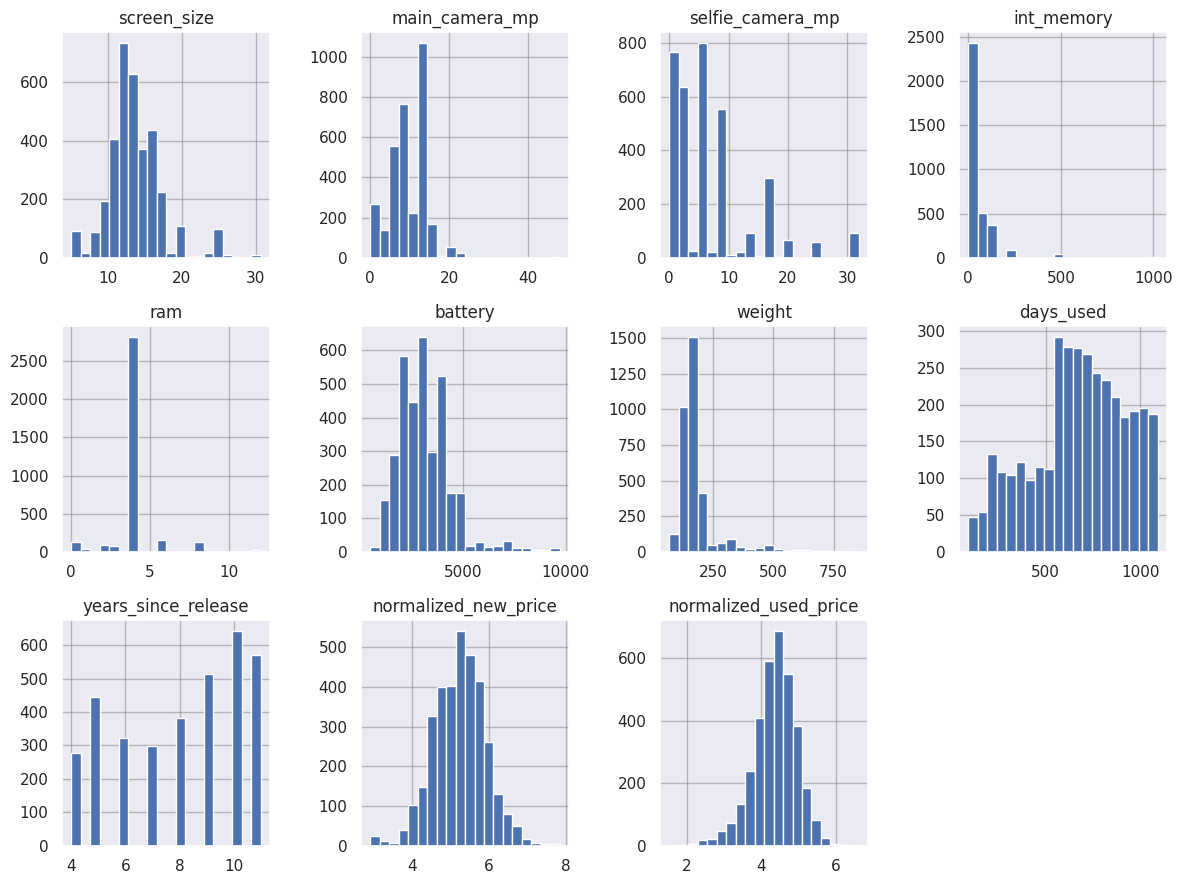

In [31]:
#Histograms of all numeric data to get feel for distributions and spot any values that might need treatment
df1[num_cols].hist(figsize = (12,9), layout = (3,4), bins = 20)
plt.tight_layout()
plt.show()

* First want to draw attention to the y-axis scales.
  * `ram` and `internal memory` both have a high frequency value, representing the majority of the data. This implies that they values to not change much when other features change.
  * `weight` and `main camera mp` also have a clear higher frequency group, representing about half the data set.
* The only features showing a normal distribution are the `new price` and the `used price`, with `screen size` a possible thrid feature but not nearly as clean as the price features.
* The `days used` feature has two buckets of values; phones used less than 550 days, and phones used more than 150 days. Something interesting happens to the cell phone usage from around the age of ~18 months
* If I had access to a SME I would check in on some of these features with 0 values. Are there phones from 2013+ without these components?
  * `main_camera_mp` & `selfie_camera_mp` - these correlate with eachother, and price. Outliers would have a large effect, so likely replace with medians?
  * `int_memory` - lets pull the statistics for this. If they are mostly 0s this feature then replacing with median will likely replace with a 0.
  * `ram` - could replace with mean grouped by brand
  > For now, choosing to leave these as they are since I can't be sure the 0 values are not valid data points for the model to consider - but may return to this after checking the model's performance.

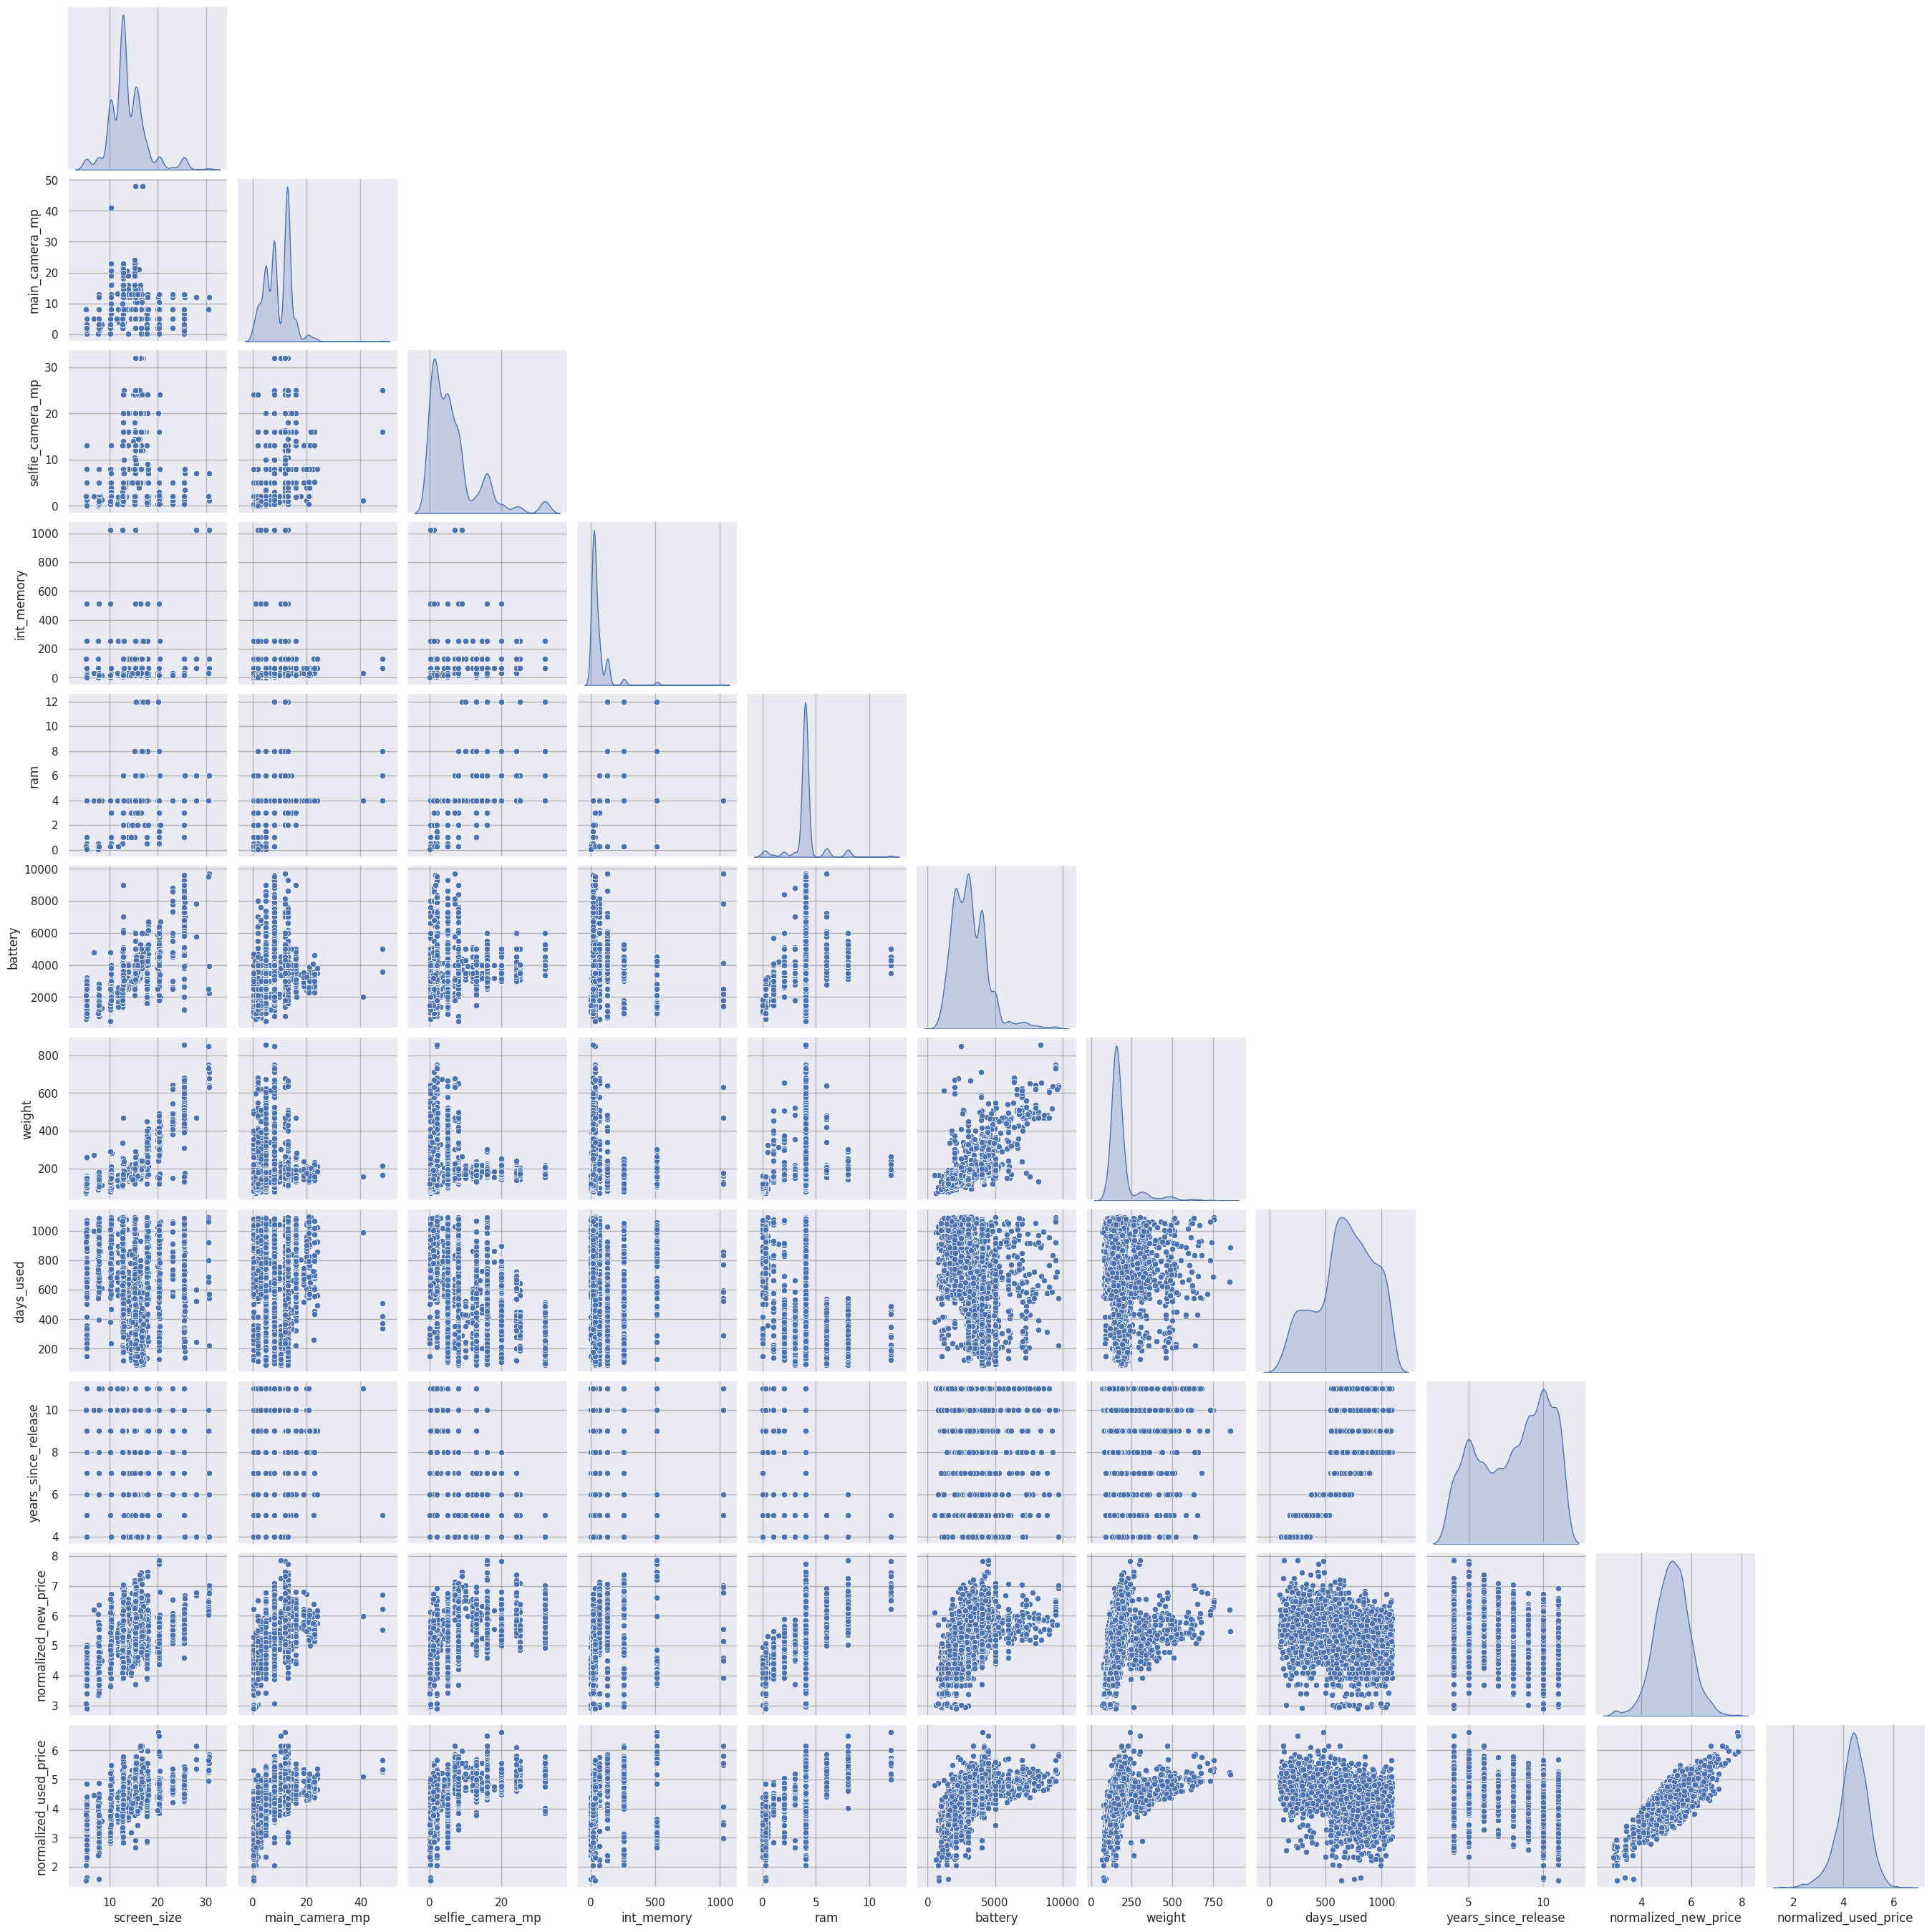

In [32]:
#pairplot the numerical columns to visualize
sns.pairplot(df1[num_cols], diag_kind='kde', corner = True)
#this was really why I rearranged the columns earlier, makes this easier to read for me

* There does not seem to be any linear relationships between used_price and the other than new_price.
* screen_size has some slight linearity with weight and battery
* weight and battery also have some linearity. My guess is that these three will show up again later in the multicollinearity work.
* There generally does not seem to be much linearity in this dataset outside of that, and several assumptions of classical linear regression seem to be violated. We will test that soon.


## Data Preprocessing

### Missing Value Treatment

We saw earlier that the features with missing values were:
* selfie_camera_mp
* int_memory
* ram
* battery
* weight
* and largest group of missing: main_camera_mp.

Additionally, we saw 0-values in positions that probably are not likely. Barring a SME to consult, we chose to leave those values as they were until we could test the model performance.

Lets work through these one by one. First:

>selfie_camera_mp

In [33]:
# Selfie Camera missing values
df1[df1['selfie_camera_mp'].isna()]

,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,days_used,years_since_release,normalized_new_price,normalized_used_price
1080,Google,Android,15.32,yes,no,12.2,NaN,64.0,4.0,3430.0,184.0,475,6,6.865974,5.573826
1081,Google,Android,12.83,yes,no,12.2,NaN,64.0,4.0,2915.0,148.0,424,6,6.745083,4.464988


A quick search shows that these are probably the Pixel 3 and 3 XL, since Google only has one main line of cell phones, and those were the two released in 2018. They both had 8 mp selfie cameras.
[Source](https://www.gsmarena.com/google_pixel_3-9256.php)

In [34]:
#replace the two selfie camera NaN with the value 8
df1['selfie_camera_mp'].fillna(8, inplace= True)

> int_memory

We know from EDA that int_memory is a interger variable that is highly skewed and with a stong mode. It correlates best with `main camera mp`. All of the belwo are Nokia phones. Thus, we will impute with the median value to limit the effecot of outliers on this variable.

In [35]:
df1[df1['int_memory'].isna()]

,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,days_used,years_since_release,normalized_new_price,normalized_used_price
117,Nokia,Others,5.18,yes,no,0.3,0.0,NaN,0.02,1200.0,86.5,234,5,3.688379,2.721295
2035,Nokia,Others,5.18,no,no,5.0,0.0,NaN,0.03,1020.0,157.0,501,5,3.420346,2.343727
2064,Nokia,Others,5.18,no,no,0.3,0.0,NaN,0.02,1100.0,78.4,559,9,3.378611,2.587012
2092,Nokia,Others,7.62,no,no,5.0,0.0,NaN,0.02,1010.0,100.0,1043,11,4.370586,3.535728


In [36]:
#replace four internal memory NaN with median of the internal memory of Nokia phones by main camera mp
df1["int_memory"] = df1["int_memory"].fillna(
    value=df1[df1['brand_name'] == 'Nokia'].groupby(["brand_name", "main_camera_mp"])["int_memory"].transform("median")
)

> RAM

We know from EDA that `RAM` is functionally a integer variable with a stong mode. `RAM` correlates strongest with the two `price` features. All of the below data points are again Nokia phones. We will chose the median for Nokia Phones for these missing values.

In [37]:
df1[df1['ram'].isna()]

,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,days_used,years_since_release,normalized_new_price,normalized_used_price
114,Nokia,Others,5.18,no,no,0.3,0.0,0.06,NaN,1020.0,91.3,288,4,2.911263,2.729159
335,Nokia,Others,5.18,no,no,0.3,0.0,0.10,NaN,1200.0,88.2,327,4,3.689129,3.062924
2059,Nokia,Others,5.18,no,no,0.3,0.0,0.06,NaN,NaN,82.6,1023,8,3.657905,2.765060
2090,Nokia,Others,7.62,no,no,5.0,0.0,0.06,NaN,1200.0,111.4,1001,11,4.605770,3.827771


In [38]:
#replace four ram NaN with median of the ram of Nokia phones
df1["ram"] = df1["ram"].fillna(
    value=df1[df1['brand_name'] == 'Nokia'].groupby(["brand_name"])['ram'].transform('median')
)

> battery

We know from EDA that `battery` is a lightly skewed continuous variable with strong positive correlations with `screen size` and `weight`. We will chose the median `battery` capacity.

In [39]:
df1[df1['battery'].isna()]

,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,days_used,years_since_release,normalized_new_price,normalized_used_price
1829,Meizu,Android,12.83,yes,no,13.0,5.0,16.00,4.00,NaN,145.0,986,10,4.863604,4.177919
1831,Meizu,Android,12.83,yes,no,20.7,5.0,16.00,4.00,NaN,158.0,1043,10,5.990639,4.878855
1832,Meizu,Android,13.61,yes,no,20.7,2.0,16.00,4.00,NaN,147.0,1007,10,5.826118,4.742320
1962,Microsoft,Windows,25.55,no,no,5.0,3.5,32.00,4.00,NaN,675.9,931,11,5.802753,5.230574
2058,Nokia,Others,5.18,no,no,0.3,0.0,0.06,0.02,NaN,81.0,815,8,3.374511,2.718660
2059,Nokia,Others,5.18,no,no,0.3,0.0,0.06,4.00,NaN,82.6,1023,8,3.657905,2.765060


In [40]:
#replace battery NaN with median of the batteries
df1['battery'] = df1['battery'].fillna(
    value = df1['battery'].median()
)


> weight

We know from EDA that `weight` is a highly skewed continuous variable with a strong mode. It positively correlates strongly with `battery` capacity and `screen size`. We will again chose the median `weight`.

In [41]:
df1[df1['weight'].isna()]

,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,days_used,years_since_release,normalized_new_price,normalized_used_price
3002,XOLO,Android,12.70,yes,no,13.0,5.0,32.0,4.0,2400.0,NaN,576,9,4.930437,4.165890
3003,XOLO,Android,12.83,yes,no,8.0,5.0,16.0,4.0,3200.0,NaN,800,9,5.189228,4.282068
3004,XOLO,Android,12.70,no,no,8.0,2.0,32.0,4.0,2100.0,NaN,878,9,4.081090,3.879706
3005,XOLO,Android,10.29,no,no,5.0,0.3,32.0,4.0,1800.0,NaN,1036,9,4.396053,3.823847
3006,XOLO,Android,12.70,no,no,5.0,0.3,16.0,4.0,2500.0,NaN,679,9,4.347176,3.837084
3007,XOLO,Windows,12.70,no,no,8.0,2.0,32.0,4.0,2200.0,NaN,838,9,4.791733,3.707210
3008,XOLO,Android,12.70,no,no,8.0,5.0,32.0,4.0,2500.0,NaN,1045,9,4.785406,4.184642


In [42]:
#replace battery NaN with median of the batteries
df1['weight'] = df1['weight'].fillna(
    value=df1[df1['brand_name'] == 'XOLO'].groupby(["brand_name"])['weight'].transform('median')
)

> main_camera_mp

Finally the largest missing group. We know from EDA that `main camera mp` is decently scewed and strongly positively correlates with the `price` variables. The price variables are continuous such that many class values only have single data point membership, so grouping on them as is will not help. Instead we will group_by the `selfie camera mp` as those two features share a correlation of 0.43

In [43]:
df1[df1['main_camera_mp'].isna()]

,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,days_used,years_since_release,normalized_new_price,normalized_used_price
59,Infinix,Android,17.32,yes,no,NaN,8.0,32.0,2.0,6000.0,209.0,245,4,4.597642,4.282068
60,Infinix,Android,15.39,yes,no,NaN,8.0,64.0,4.0,5000.0,185.0,173,4,4.711780,4.363608
61,Infinix,Android,15.39,yes,no,NaN,8.0,32.0,2.0,5000.0,185.0,256,4,4.505460,4.181439
62,Infinix,Android,15.39,yes,no,NaN,16.0,32.0,3.0,4000.0,178.0,316,5,4.602166,4.555244
63,Infinix,Android,15.29,yes,no,NaN,16.0,32.0,2.0,4000.0,165.0,468,5,4.871297,4.416670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3411,Realme,Android,15.34,yes,no,NaN,16.0,64.0,4.0,4000.0,183.0,503,5,5.159974,4.570475
3412,Realme,Android,15.32,yes,no,NaN,16.0,64.0,4.0,4035.0,184.0,433,5,5.074424,4.521027
3413,Realme,Android,15.32,yes,no,NaN,25.0,64.0,4.0,4045.0,172.0,288,5,4.966753,4.778199
3448,Asus,Android,16.74,yes,no,NaN,24.0,128.0,8.0,6000.0,240.0,325,5,7.059317,5.715316


In [44]:
# replace main_camra_mp NaN with median of the main camera mps
df1['main_camera_mp'] = df1['main_camera_mp'].fillna(
    value=df1.groupby('selfie_camera_mp')['main_camera_mp'].transform('median')
)

# Last Check
df1.isnull().sum()

brand_name               0
os                       0
screen_size              0
4g                       0
5g                       0
main_camera_mp           0
selfie_camera_mp         0
int_memory               0
ram                      0
battery                  0
weight                   0
days_used                0
years_since_release      0
normalized_new_price     0
normalized_used_price    0
dtype: int64

No additional NaN values appear at this time.


### Outlier Detection and Treatment

We already know there are going to be a fair number of outliers from our EDA work. The question is if any of the outliers need treatment.

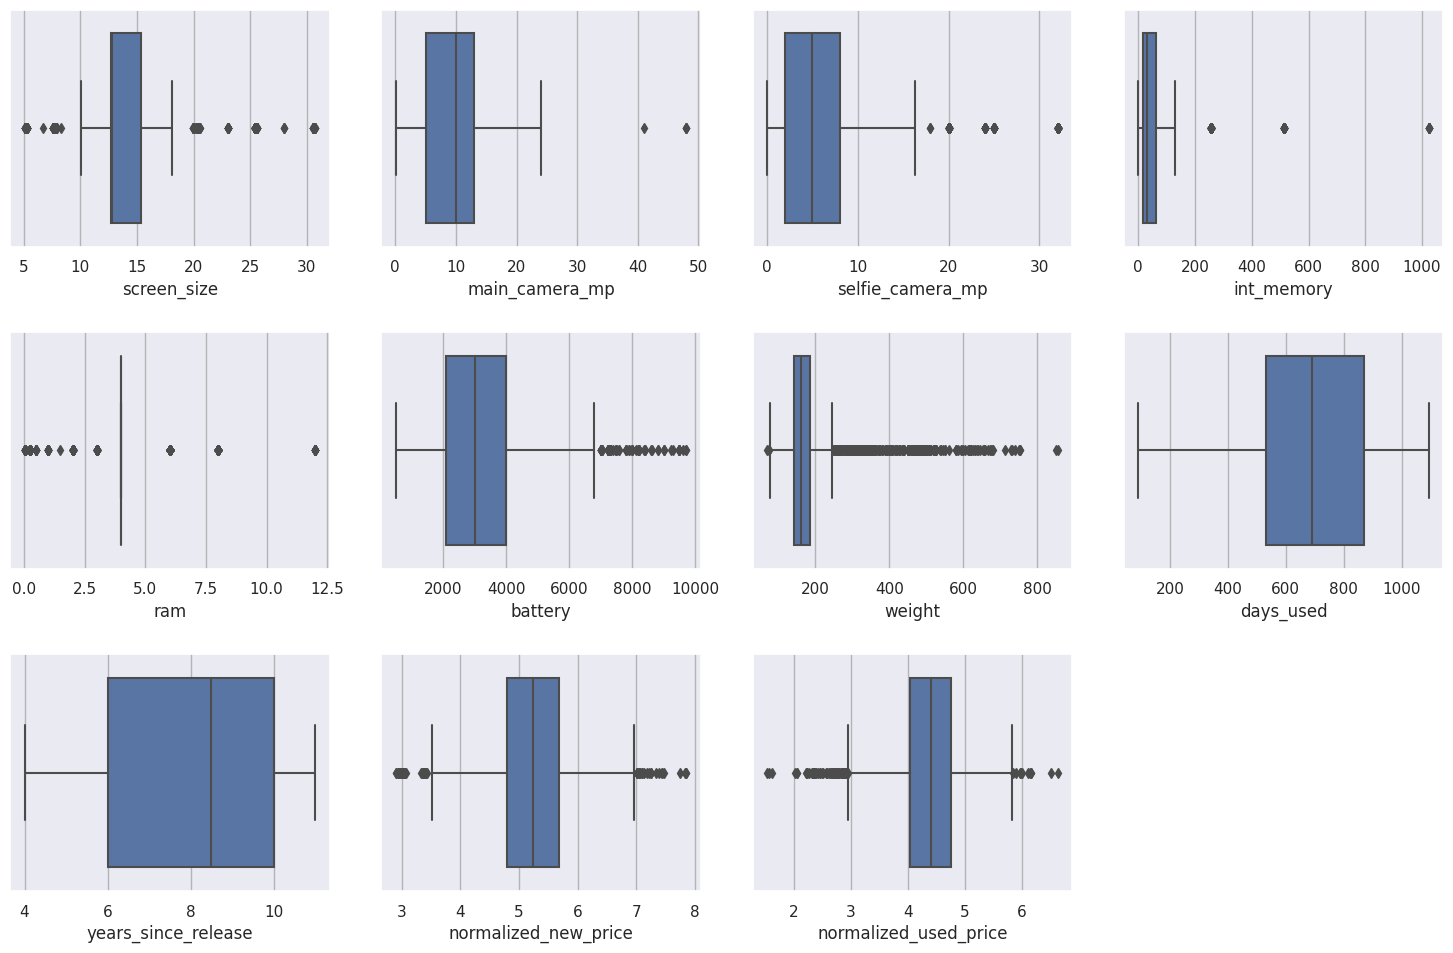

In [45]:
# outlier detection using boxplot
num_cols = df1.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(15, 10))

for i, variable in enumerate(num_cols):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(data=df1, x=variable)
    plt.tight_layout(pad=2)

plt.show()

* I have no reason to reject the outliers at this time. Technical specs have a wide variety, particulary over 10 years of development. However if the performance data for the model is unsatisfactory, this is one place I will return to see what can be optimized.

### Prepare data for modeling

Order we will take here:


1.   Create Independent and Dependent Variables
2.   Add Constant to Dependent Variable
3.   Create Dummy Variables
4.   Split Data



In [46]:
# create new dataframes for variables
X = df1.drop(['normalized_used_price'], axis=1)
y = df1['normalized_used_price']

In [47]:
# add intercept to data
X = sm.add_constant(X)

In [48]:
# Create Dummy Variables for Categorical features

# drop_first=True will drop the first variable of each type. This will become the base line for the coeffiencient analysis.
X = pd.get_dummies(
    X,
    columns=X.select_dtypes(include=["object", "category"]).columns.tolist(),
    drop_first=True,
)
X.head()

,const,screen_size,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,days_used,years_since_release,...,brand_name_Spice,brand_name_Vivo,brand_name_XOLO,brand_name_Xiaomi,brand_name_ZTE,os_Others,os_Windows,os_iOS,4g_yes,5g_yes
0,1.0,14.50,13.0,5.0,64.0,3.0,3020.0,146.0,127,4,...,0,0,0,0,0,0,0,0,1,0
1,1.0,17.30,13.0,16.0,128.0,8.0,4300.0,213.0,325,4,...,0,0,0,0,0,0,0,0,1,1
2,1.0,16.69,13.0,8.0,128.0,8.0,4200.0,213.0,162,4,...,0,0,0,0,0,0,0,0,1,1
3,1.0,25.50,13.0,8.0,64.0,6.0,7250.0,480.0,345,4,...,0,0,0,0,0,0,0,0,1,1
4,1.0,15.32,13.0,8.0,64.0,3.0,5000.0,185.0,293,4,...,0,0,0,0,0,0,0,0,1,0


In [49]:
# Splitting data in train and test sets
# because our target variable is continuous, there are many values in the Y data set that only occur once.
# thus we cant stratify this data set.
# choosing random_state=1 so this is replicable
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=1
)

In [50]:
# check to see if split worked correctly
print("Number of rows in train data =", X_train.shape[0])
print("Number of rows in test data =", X_test.shape[0])

Number of rows in train data = 2417
Number of rows in test data = 1037


## Model Building - Linear Regression

In [51]:
olsmodel = sm.OLS(y_train, X_train).fit()
print(olsmodel.summary())

                              OLS Regression Results                             
Dep. Variable:     normalized_used_price   R-squared:                       0.845
Model:                               OLS   Adj. R-squared:                  0.841
Method:                    Least Squares   F-statistic:                     268.2
Date:                   Fri, 12 Jan 2024   Prob (F-statistic):               0.00
Time:                           20:00:13   Log-Likelihood:                 121.93
No. Observations:                   2417   AIC:                            -145.9
Df Residuals:                       2368   BIC:                             137.9
Df Model:                             48                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


# **Initial Regression Result Interpretation**

1. **Adjusted. R-squared**: It reflects the fit of the model.
    - Adjusted R-squared values generally range from 0 to 1, where a higher value generally indicates a better fit, assuming certain conditions are met.
    - In our case, the value for adj. R-squared is **0.842**, which is a great starting point.


2. ***const* coefficient**: It is the Y-intercept.
    - It means that if all the predictor variable coefficients are zero, then the expected output (i.e., Y) would be equal to the *const* coefficient.
    - In our case, the value for `const` coefficient is **1.3582**


3. **Coefficient of a predictor variable**: It represents the change in the output Y due to a change in the predictor variable (everything else held constant).
    - In our case, the coefficient of `normalized new price` is **0.4307** which is quite large, but if you are the person selling or trading in your used device you might not think so.

## Model Performance Check

Running a performance check no, prior to multicollinearity, gives us a comparison starting point gor our main metrics. The metrics we will be using to judge the model today are;
* RMSE
* MAE
* $R^2$
* Adjusted $R^2$
* MAPE - this will be interesting as several of our features are equal to 0, there are many extreme values and thus outliers in the data set. We will need to be careful with this metric, particularly early.

In [52]:
# We need a few custom functions to find the state metrics
# Then we will summarize those metrics in a chart

# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

We can compare these metrics for our Training and Test performance data. The inside the custom function **model_performance_regression**, it calculates the predictions using the model and the independent variable. These predictions are then compared to the actual target data to test performance.

In [53]:
# checking model performance on train set (seen 70% data)
print("Training Performance\n")
olsmodel_train_perf = model_performance_regression(olsmodel, X_train, y_train)
print(olsmodel_train_perf, "\n\n")

# checking model performance on test set (seen 30% data)
print("Test Performance\n")
olsmodel_test_perf = model_performance_regression(olsmodel, X_test, y_test)
print(olsmodel_test_perf)

Training Performance

       RMSE       MAE  R-squared  Adj. R-squared      MAPE
0  0.230067  0.180513   0.844638        0.841422  4.331739 


Test Performance

       RMSE       MAE  R-squared  Adj. R-squared      MAPE
0  0.238749  0.185047   0.841962        0.834117  4.509903


* The train and test values for all metrics are comprable - this is evidence that our model is not overfitting to the train data set.
* The training $R^2$ is 0.841, so the model is also not underfitting.
* MAE suggests that the model can currently predict the normalized used cost of a device with a mean error of 0.18 on the test data
* The MAPE of 4.5 on the rest data means that we are able to predict the cost of a used device within 4.5%

### Multicollinearity

This fucntion will produce a chart of VIFs for each feature.

In [54]:
def checking_vif(predictors):
    vif = pd.DataFrame()
    vif["feature"] = predictors.columns

    # calculating VIF for each feature
    vif["VIF"] = [
        variance_inflation_factor(predictors.values, i)
        for i in range(len(predictors.columns))
    ]
    return vif

In [55]:
vif_df = checking_vif(X_train).sort_values(by = "VIF")
vif_df

,feature,VIF
22,brand_name_Infinix,1.287613
18,brand_name_Google,1.321784
4,int_memory,1.364595
32,brand_name_OnePlus,1.437127
16,brand_name_Coolpad,1.467947
23,brand_name_Karbonn,1.573730
45,os_Windows,1.595359
14,brand_name_BlackBerry,1.633748
39,brand_name_Spice,1.688904
25,brand_name_Lava,1.712289


To remove multicollinearity

1. Drop every column one by one that has a VIF score greater than  5. However, the dummy variables can be ignores.
2. Look at the adjusted R-squared and RMSE of all these models.
3. Drop the variable that makes the least change in adjusted R-squared.
4. Check the VIF scores again.
5. Continue till you get all VIF scores under 5.

Let's define a function that will help us do this.

In [56]:
def treating_multicollinearity(predictors, target, high_vif_columns):
    """
    Checking the effect of dropping the columns showing high multicollinearity
    on model performance (adj. R-squared and RMSE)

    predictors: independent variables
    target: dependent variable
    high_vif_columns: columns having high VIF
    """
    # empty lists to store adj. R-squared and RMSE values
    adj_r2 = []
    rmse = []

    # build ols models by dropping one of the high VIF columns at a time
    # store the adjusted R-squared and RMSE in the lists defined previously
    for cols in high_vif_columns:
        # defining the new train set
        train = predictors.loc[:, ~predictors.columns.str.startswith(cols)]

        # create the model
        olsmodel = sm.OLS(target, train).fit()

        # adding adj. R-squared and RMSE to the lists
        adj_r2.append(olsmodel.rsquared_adj)
        rmse.append(np.sqrt(olsmodel.mse_resid))

    # creating a dataframe for the results
    temp = pd.DataFrame(
        {
            "col": high_vif_columns,
            "Adj. R-squared after_dropping col": adj_r2,
            "RMSE after dropping col": rmse,
        }
    ).sort_values(by="Adj. R-squared after_dropping col", ascending=False)
    temp.reset_index(drop=True, inplace=True)

    return temp

In [57]:
# Since the very beginning, the high correlation between battery, screen size, and weight has been noted
#lets start with those as they are the highest non - dummy VIF values
col_list = ['screen_size', 'weight', 'battery']
res = treating_multicollinearity(X_train, y_train, col_list)
res

,col,Adj. R-squared after_dropping col,RMSE after dropping col
0,battery,0.841196,0.232650
1,screen_size,0.838092,0.234913
2,weight,0.837847,0.235090


The original adjusted $R^2$ wass 0.841. The smallest drop in $R^2$ was for the battery feature. This one will be removed first. Then we will check VIF again:

In [58]:
col_to_drop = "battery"
X_train2 = X_train.loc[:, ~X_train.columns.str.startswith(col_to_drop)]
X_test2 = X_test.loc[:, ~X_test.columns.str.startswith(col_to_drop)]

# Check VIF now
vif = checking_vif(X_train2)
print("VIF after dropping ", col_to_drop)
vif.sort_values(by = "VIF")

VIF after dropping  battery


,feature,VIF
21,brand_name_Infinix,1.279237
17,brand_name_Google,1.321437
4,int_memory,1.364594
31,brand_name_OnePlus,1.437122
15,brand_name_Coolpad,1.467752
22,brand_name_Karbonn,1.572098
44,os_Windows,1.593486
13,brand_name_BlackBerry,1.633610
38,brand_name_Spice,1.688748
24,brand_name_Lava,1.712280


Still have `screen_size` and `weight` VIF values greater than 5, so we will keep going:

In [59]:
col_list = ['screen_size', 'weight']
res = treating_multicollinearity(X_train, y_train, col_list)
res

,col,Adj. R-squared after_dropping col,RMSE after dropping col
0,screen_size,0.838092,0.234913
1,weight,0.837847,0.235090


The original adjusted $R^2$ wass 0.841. The smallest drop in $R^2$ was for the screen_size feature. This one will be our 2nd removed variable. Then we will check VIF again:

In [60]:
col_to_drop = "screen_size"
X_train3 = X_train2.loc[:, ~X_train2.columns.str.startswith(col_to_drop)]
X_test3 = X_test2.loc[:, ~X_test2.columns.str.startswith(col_to_drop)]

# Check VIF now
vif = checking_vif(X_train3)
print("VIF after dropping ", col_to_drop)
vif

VIF after dropping  screen_size


,feature,VIF
0,const,215.009771
1,main_camera_mp,2.270808
2,selfie_camera_mp,2.803120
3,int_memory,1.362429
4,ram,2.256720
5,weight,1.366582
6,days_used,2.645792
7,years_since_release,4.491322
8,normalized_new_price,3.061021
9,brand_name_Alcatel,3.401010


The VIF for weight dropped drammatically to 1.366. This means that our model only needs to look at weight, the screen_size and battery capacity were too multicollinear.

The only remaining VIF points greater than 5 are dummy variables. The years_since_release VIF is equal to 4.49 which is close to the traditional cut of of a VIF value of 5. We can come back to this if necessary.

In [61]:
olsmodel3 = sm.OLS(y_train, X_train3).fit()
print(olsmodel3.summary())

                              OLS Regression Results                             
Dep. Variable:     normalized_used_price   R-squared:                       0.841
Model:                               OLS   Adj. R-squared:                  0.838
Method:                    Least Squares   F-statistic:                     273.0
Date:                   Fri, 12 Jan 2024   Prob (F-statistic):               0.00
Time:                           20:00:16   Log-Likelihood:                 95.609
No. Observations:                   2417   AIC:                            -97.22
Df Residuals:                       2370   BIC:                             174.9
Df Model:                             46                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


In [62]:
# checking model performance on train set (seen 70% data)
print("Training Performance - Model 1\n")
olsmodel_train_perf = model_performance_regression(olsmodel, X_train, y_train)
print(olsmodel_train_perf, "\n\n")

# checking model performance on test set (seen 30% data)
print("Test Performance- Model 1\n")
olsmodel_test_perf = model_performance_regression(olsmodel, X_test, y_test)
print(olsmodel_test_perf, "\n\n")

# checking model performance on train set (seen 70% data)
print("Training Performance- Model 3\n")
olsmodel_train_perf = model_performance_regression(olsmodel3, X_train3, y_train)
print(olsmodel_train_perf, "\n\n")

# checking model performance on test set (seen 30% data)
print("Test Performance - Model 3\n")
olsmodel_test_perf = model_performance_regression(olsmodel3, X_test3, y_test)
print(olsmodel_test_perf)

Training Performance - Model 1

       RMSE       MAE  R-squared  Adj. R-squared      MAPE
0  0.230067  0.180513   0.844638        0.841422  4.331739 


Test Performance- Model 1

       RMSE       MAE  R-squared  Adj. R-squared      MAPE
0  0.238749  0.185047   0.841962        0.834117  4.509903 


Training Performance- Model 3

       RMSE       MAE  R-squared  Adj. R-squared      MAPE
0  0.232586  0.181761   0.841218        0.838068  4.370381 


Test Performance - Model 3

      RMSE       MAE  R-squared  Adj. R-squared      MAPE
0  0.24301  0.188755    0.83627         0.82849  4.605767


Based on this data - Model 1 (all data) is actually stronger in predictive accuracy than Model 3 (remvoe two multicollinear points). However, we are not done quite yet, we will look at p-values next. The benefit of Model 3 is that it is less complex and thus easier to interpret. It is possible that Model 1 was slightly overfit, and now Model 3 is slightly underfit. Further, the drop in these performance measurements, while noticible, are actually still quite small.

We shall carry on in the process with knowledge of the trade off between performance and complexity.

### Analysis of high p-value variables - Independence of Features

Next, a similar iterative process to drop variables with high p-values. A "high" p-value is defined as greater that 0.05, a chosen significant level. The null hypothese is that each independent feature is not significant. Thus, a p-value greater that 0.05 confirms thathypothese - the feature is not significant and can be removed.

This iterates similarly in concept to how we approached the VIF values for multicolinearity - we will remove one variable at a time and recalculate the model to see the effect on other p-values. This repeates until all features have p-values less than 0.05, until all independent features are significant.

However, two big changes: we can now remove dummy variables without concern and we can write a while loop to step through the interation for us. The below function will produce a list of features that are selected as significant. We then fit a new model to just those features.

In [63]:
# initial list of columns
predictors = X_train3.copy()
cols = predictors.columns.tolist()

# setting an initial max p-value
max_p_value = 1

while len(cols) > 0:
    # defining the train set
    X_train_aux = predictors[cols]

    # fitting the model
    model = sm.OLS(y_train, X_train_aux).fit()

    # getting the p-values and the maximum p-value
    p_values = model.pvalues
    max_p_value = max(p_values)

    # name of the variable with maximum p-value
    feature_with_p_max = p_values.idxmax()

    if max_p_value > 0.05:
        cols.remove(feature_with_p_max)
    else:
        break

selected_features = cols
print(selected_features)

['const', 'main_camera_mp', 'selfie_camera_mp', 'ram', 'weight', 'years_since_release', 'normalized_new_price', 'brand_name_Karbonn', 'brand_name_Samsung', 'brand_name_Sony', 'brand_name_Xiaomi', 'os_Others', 'os_iOS', '4g_yes', '5g_yes']


We not take that to make Model #4:

In [64]:
# Select only the features selected as significant from data set 3:
X_train4 = X_train3[selected_features]
X_test4 = X_test3[selected_features]

# and create Model #4
olsmodel4 = sm.OLS(y_train, X_train4).fit()
print(olsmodel4.summary())

                              OLS Regression Results                             
Dep. Variable:     normalized_used_price   R-squared:                       0.839
Model:                               OLS   Adj. R-squared:                  0.838
Method:                    Least Squares   F-statistic:                     894.9
Date:                   Fri, 12 Jan 2024   Prob (F-statistic):               0.00
Time:                           20:00:17   Log-Likelihood:                 79.741
No. Observations:                   2417   AIC:                            -129.5
Df Residuals:                       2402   BIC:                            -42.63
Df Model:                             14                                         
Covariance Type:               nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
co

Check the performance;

In [65]:
# checking model performance on train set (seen 70% data)
print("Training Performance - Model 1\n")
olsmodel_train_perf = model_performance_regression(olsmodel, X_train, y_train)
print(olsmodel_train_perf, "\n\n")

# checking model performance on test set (seen 30% data)
print("Test Performance- Model 1\n")
olsmodel_test_perf = model_performance_regression(olsmodel, X_test, y_test)
print(olsmodel_test_perf, "\n\n")

# checking model performance on train set (seen 70% data)
print("Training Performance- Model 4\n")
olsmodel_train_perf = model_performance_regression(olsmodel4, X_train4, y_train)
print(olsmodel_train_perf, "\n\n")

# checking model performance on test set (seen 30% data)
print("Test Performance - Model 4\n")
olsmodel_test_perf = model_performance_regression(olsmodel4, X_test4, y_test)
print(olsmodel_test_perf)

Training Performance - Model 1

       RMSE       MAE  R-squared  Adj. R-squared      MAPE
0  0.230067  0.180513   0.844638        0.841422  4.331739 


Test Performance- Model 1

       RMSE       MAE  R-squared  Adj. R-squared      MAPE
0  0.238749  0.185047   0.841962        0.834117  4.509903 


Training Performance- Model 4

       RMSE       MAE  R-squared  Adj. R-squared     MAPE
0  0.234118  0.182771   0.839119        0.838114  4.39565 


Test Performance - Model 4

       RMSE       MAE  R-squared  Adj. R-squared     MAPE
0  0.241513  0.186707   0.838281        0.835905  4.55824


### Analysis of Performance Metrics

Once again we see that Model 1 slighlty outperforms Model 4. However, Model 4 is significantly less complex and the drop in performance is not significant. Model 4 is still performing very well. Here is a more detailed look at what each of these Performance Metrics actually mean;

* **RMSE** is a measure of minimization of prediction errors. Said another way, a lower RMSE means that a model is minimizing errors. Our target variable is normalized (which we will prove shortly) with a minimum of 1.5 and a maximum of 6.2. The RMSE of 0.24 on that scale is about a 6% error swing. Thus the margins of the buisness model must keep that in mind for risk calculations.

* **MAE** is similar, it is the absoulte error. A smaler MAE means that the predictions are closer to the "true" values. MAE is 0.19, which again on our target variable range is about a 4% error.

* **MAPE**  takes the MAE and instead considers the percent error, as already discussed!

* **Adjusted $R^2$ and $R^2$** work together to comment on complexity. Adjusted $R^2$ penalizes models with to omuch complexity because of the inclusion of the number of predictors (features) included in the model. When it decreases, it means that variables removed did indeed have some explanatory power. In this case the decrease is very small. It is also worth noting that the two variables removed by multicollinearity; `screen_size` and `battery` had more variability than `weight`, a feature whose values had a strong modal tendency. This means that removing `weight` would have a greater effect on the model, but we did lose some nuance with the removal of the more variable features of the trio.



## Checking Linear Regression Assumptions

We will be checking the following Linear Regression assumptions:

1. **Linearity of variables**

2. **Independence of error terms**

3. **Normality of error terms**

4. **No Heteroscedasticity**

### Linearity and Independence

We will plot the fitted values vs the residuals for model 4. We are hoping to see no pattern in the data - showing that the residuals are independent and the model is linear.

In [66]:
# let us create a dataframe with actual, fitted and residual values
df_pred = pd.DataFrame()

df_pred["Actual Values"] = y_train  # actual values
df_pred["Fitted Values"] = olsmodel4.fittedvalues  # predicted values
df_pred["Residuals"] = olsmodel4.resid  # residuals

df_pred.head()

,Actual Values,Fitted Values,Residuals
3026,4.087488,3.867212,0.220276
1525,4.448399,4.600978,-0.152578
1128,4.315353,4.286047,0.029306
3003,4.282068,4.195229,0.086839
2907,4.456438,4.489618,-0.033180


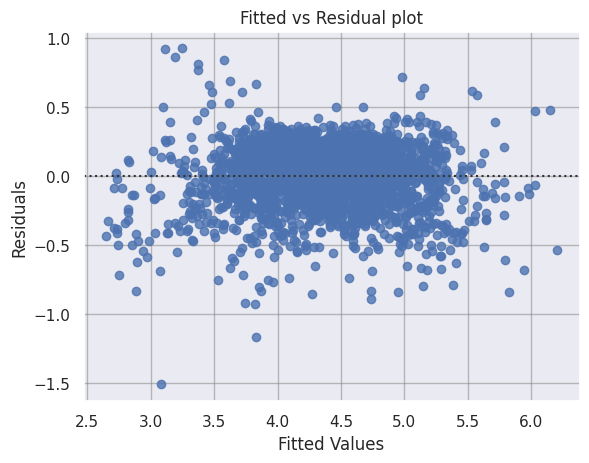

In [67]:
# let's plot the fitted values vs residuals

sns.residplot(
    data=df_pred, x="Fitted Values", y="Residuals"
)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Fitted vs Residual plot")
plt.show()

The scatter plot shows the distribution of residuals (errors) vs fitted values (predicted values).

If there exist any pattern in this plot, we consider it as signs of non-linearity in the data and a pattern means that the model doesn't capture non-linear effects.

We see no real pattern in the plot above it - it is generally ovoid but there isnt a clear curve or funnel. But we will also test the homoscedasticity of the model in a moment to help build the case for the strengths or limitations of the model. For now, the assumptions of linearity and independence are mediocre-ly satisfied. This is likely due to the large number of zeros in our data set - which could be fixed with some time with a SME or it could be a reality of this market.

### Test for Normality

An assumption of this model is that the residuals are normally distributed - this allows appropriate sized and stability in confidence intervals. In order to rest the assumption, we will look at three indicators of normality; a Histogram, a Q-Q plot, and a Shapiro-Wilk test.

We already know there are unusual data points in the data set, so this discussion will be how crucial further discussions of those unusual data points will be.

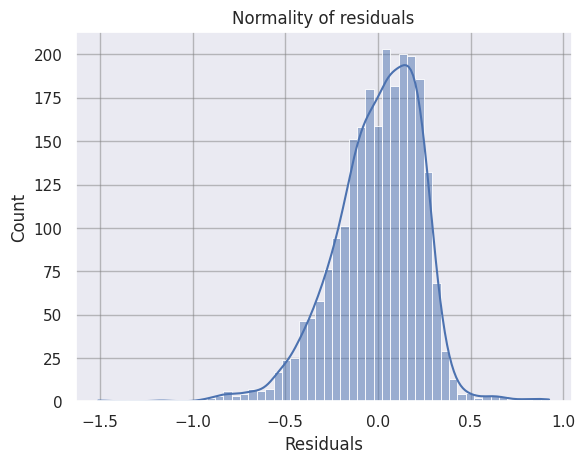

In [68]:
sns.histplot(data=df_pred, x="Residuals", kde=True)
plt.title("Normality of residuals")
plt.show()

Its more bell shaped than I expected! There are moredata points on the left of the data, but the data is nearly symmetric about residuals = 0.0.

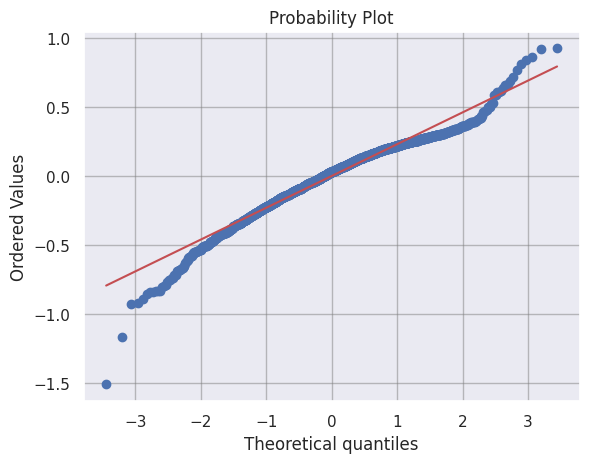

In [69]:
# Q-Q plot
stats.probplot(df_pred["Residuals"], dist="norm", plot=pylab)
plt.show()

The tails on this data is pretty rough - evidence that a quality SME is worth the investement.

In [70]:
# Shapiro-Wilk test
stats.shapiro(df_pred["Residuals"])

ShapiroResult(statistic=0.9674226641654968, pvalue=5.645825118302675e-23)

The p-value is significantly less than 0.05, thus the residuals are NOT normal as per the Shapiro -Wilk test. Generally speaking we can say that the assumption is once again only mediocre-ly satisfied, and further data prep work will increase the normalcy of the residuals.

### Test for Homoscedasticity

Whereas the previous section worked with the assumption that the magnitude of the residuals were normally distrubuted, homoscedasticity looks at the distribution of the residuals across the regression line itself. The presence of outliers, a known issue in this data, reduces homoscedasticity.

The goldfeldquant test has a null hypothese that the residuals are homoscedastic, so we are looking for p-value greater than 0.05.

In [71]:
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(df_pred["Residuals"], X_train4)
lzip(name, test)

[('F statistic', 1.0088616644571273), ('p-value', 0.43944597704581817)]

This assumption is satisfied! This is confidence building that the outliers in the data, especially as the represent specific phone models, are not harming the model. That isnt to say that the model wouldnt be improved by their treatment, however.

### Summary

The assumptions of linear regression have been, at least at a very low level, satisfied. Improvement of the data preperation, particulary in working with outliers and the presence of 0-values, would improve these metrics.

## Final Model

Lets print the final model one more time and look at some sample predictions.

In [72]:
# create new "final" independent variables
X_train_final = X_train4.copy()
X_test_final = X_test4.copy()

# this is equvalent to Model #4
olsmodel_final = sm.OLS(y_train, X_train_final).fit()
print(olsmodel_final.summary())

                              OLS Regression Results                             
Dep. Variable:     normalized_used_price   R-squared:                       0.839
Model:                               OLS   Adj. R-squared:                  0.838
Method:                    Least Squares   F-statistic:                     894.9
Date:                   Fri, 12 Jan 2024   Prob (F-statistic):               0.00
Time:                           20:00:18   Log-Likelihood:                 79.741
No. Observations:                   2417   AIC:                            -129.5
Df Residuals:                       2402   BIC:                            -42.63
Df Model:                             14                                         
Covariance Type:               nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
co

In [73]:
# predictions on the test set
pred = olsmodel_final.predict(X_test_final)

df_pred_test = pd.DataFrame({"Actual": y_test, "Predicted": pred})
df_pred_test.sample(10, random_state=1)

,Actual,Predicted
1995,4.566741,4.384396
2341,3.696103,4.003929
1913,3.592093,3.644629
688,4.306495,4.103986
650,4.522115,5.112641
2291,4.259294,4.398014
40,4.997685,5.459388
1884,3.875359,4.052498
2538,4.206631,4.036213
45,5.380450,5.228828


I would say this falls pretty firmly in the "good, not great" category!

In [74]:
print("Final Model Perofmance Metrics: Train vs Test")
# checking model performance on train set (seen 70% data)
print("Training Performance\n")
olsmodel_final_train_perf = model_performance_regression(
    olsmodel_final, X_train_final, y_train
)
print(olsmodel_final_train_perf, "\n\n")

# checking model performance on test set (seen 30% data)
print("Test Performance\n")
olsmodel_final_test_perf = model_performance_regression(
    olsmodel_final, X_test_final, y_test
)
print(olsmodel_final_test_perf)

Final Model Perofmance Metrics: Train vs Test
Training Performance

       RMSE       MAE  R-squared  Adj. R-squared     MAPE
0  0.234118  0.182771   0.839119        0.838114  4.39565 


Test Performance

       RMSE       MAE  R-squared  Adj. R-squared     MAPE
0  0.241513  0.186707   0.838281        0.835905  4.55824


These values did not shift much though the process.

* The model is able to explain ~84% of the variation in the data.
* The train and test RMSE and MAE are low (relative to the scale of the target variable) and comporable. The model is not overfitting.
* The MAPE on the test set suggests we can predict within 4.6% of the normalized used prices.
* Hence, we propose this model as a great starting tool for the buisness discussions to follow.

## Actionable Insights and Recommendations

> **Next steps in Data Analysis and Modeling Work**

1. Connecting with a subject matter expert to weigh in on the outliers, missing value treatment would be very helpful. For example, the outlier of the 1TB internal memory phone, while not common, is certainly an available devide in America. Should those outliers continue to stay?

2. Also, based ont he Business Recommendations made below, other data cleaning work could be done. For example, if the company decides to only focus on used phones from the last 4 years, we can create a new model that focuses on those parameters.

3. Update the dataset through at least 2022 and add a few more features to the data set:
 *   Based on the days used data, many people sell their devices at the 18 month mark. Thus the data set should be updated to include phones released 18 months ago.
 *   Inventory of available used devices of that model - instead of each row of data being a unique build; each row of the data set is an actual phone that was available and its selling price. This would be a huge data set, and the model straignthens with more data.
 *   Market specific categoricals; for example India is accelearting its 5g access presently, so the 5g phones will likely go up in demand now that the technology is support. More 4g phones will be available for resale as users upgrade.

> **Buisness Recommendation Based on Current model**

 1. I suggest as a buisness model to try to focus on keeping inventory of used devices that have non-zero values for the following features:
  * main camera mega pixles
  * selfie camera mega pixels
  * internal memory
  * RAM
 2. Consider focusing the buisness model, taking into consideration sourcing, technical support, repairs, resale strategy, regional partners, partnerships with connection providers, e-commerce vs brick and morter etc. Here are some focuses of devices that, when the categories are more limited may straighthen the model:
  * Consider focuses only on a few key brands. Our model suggests that Karbonn and Xiaomi might be good choices. However other buisness factors like repair costs, inventory, regional availabilty etc become relevant.
  * selfie camera mega pixels - consider only devices above the Q1 value of this data set
  * internal memory - consider only devices above the Q1 value of this data set
  * RAM - consider only devices in the 4 GB+ range
  * Market specific choices: not all phones brands or individual technologies are available worldwide.



___

# <a name='link1'>Appendix: Detailed Exploratory Data Analysis (EDA)</a>

In [75]:
# create an array for bins values to better compare the two visualizations for prices
# start at the minumum for the used price and maximum of the new price, with 0.25 steps
bins_prices = np.arange(df1['normalized_used_price'].min(),df1['normalized_new_price'].max() + 0.25, 0.25)

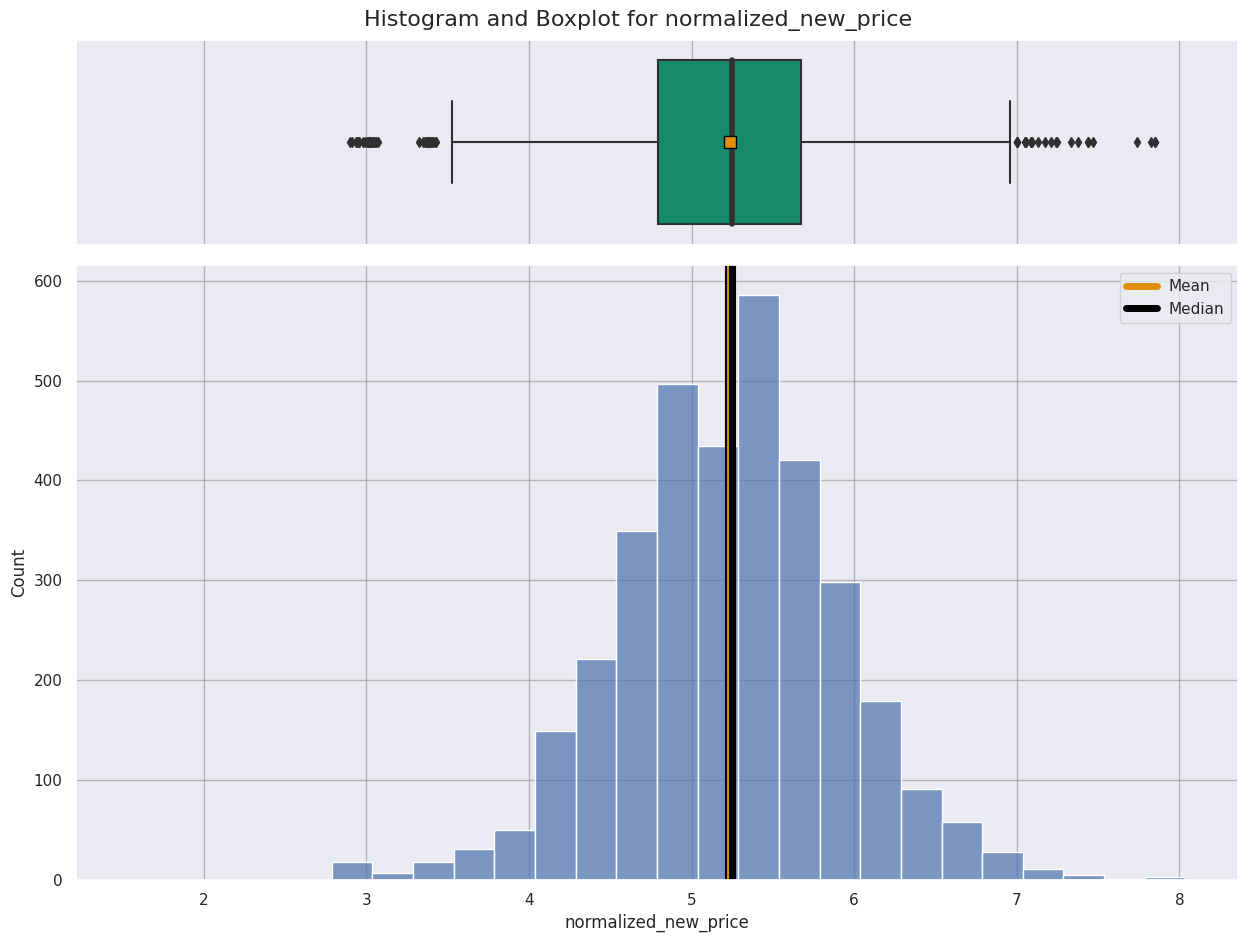

In [76]:
histogram_boxplot(df1, "normalized_new_price", bins = bins_prices)

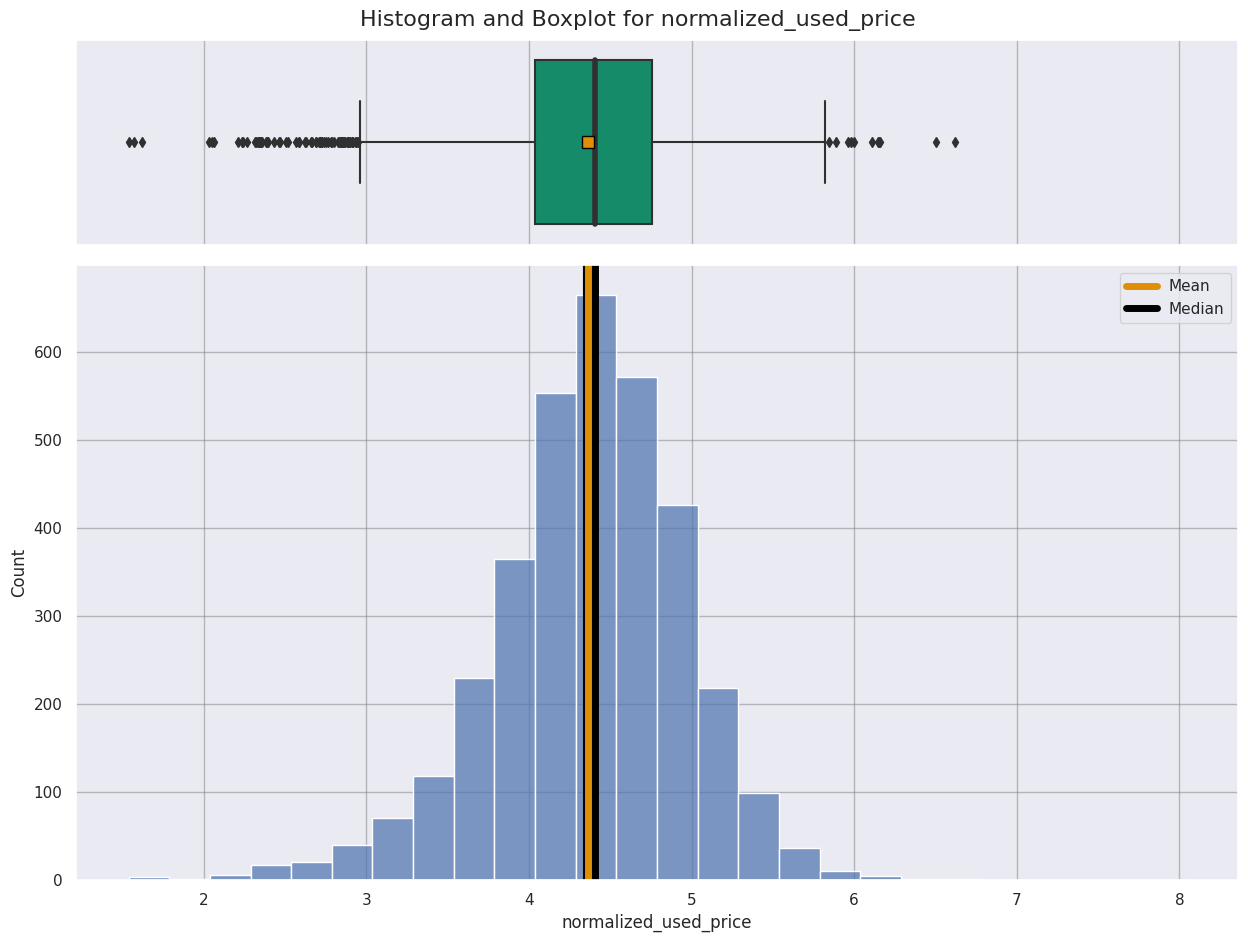

In [77]:
histogram_boxplot(df1, "normalized_used_price", bins = bins_prices)

Observations: The used prices are visually slightly more normalized, and has more outliers less than the Q1 value. The new prices are such that the median and mean are less than the mode; the histogram is normalized but not purely symetrical.  

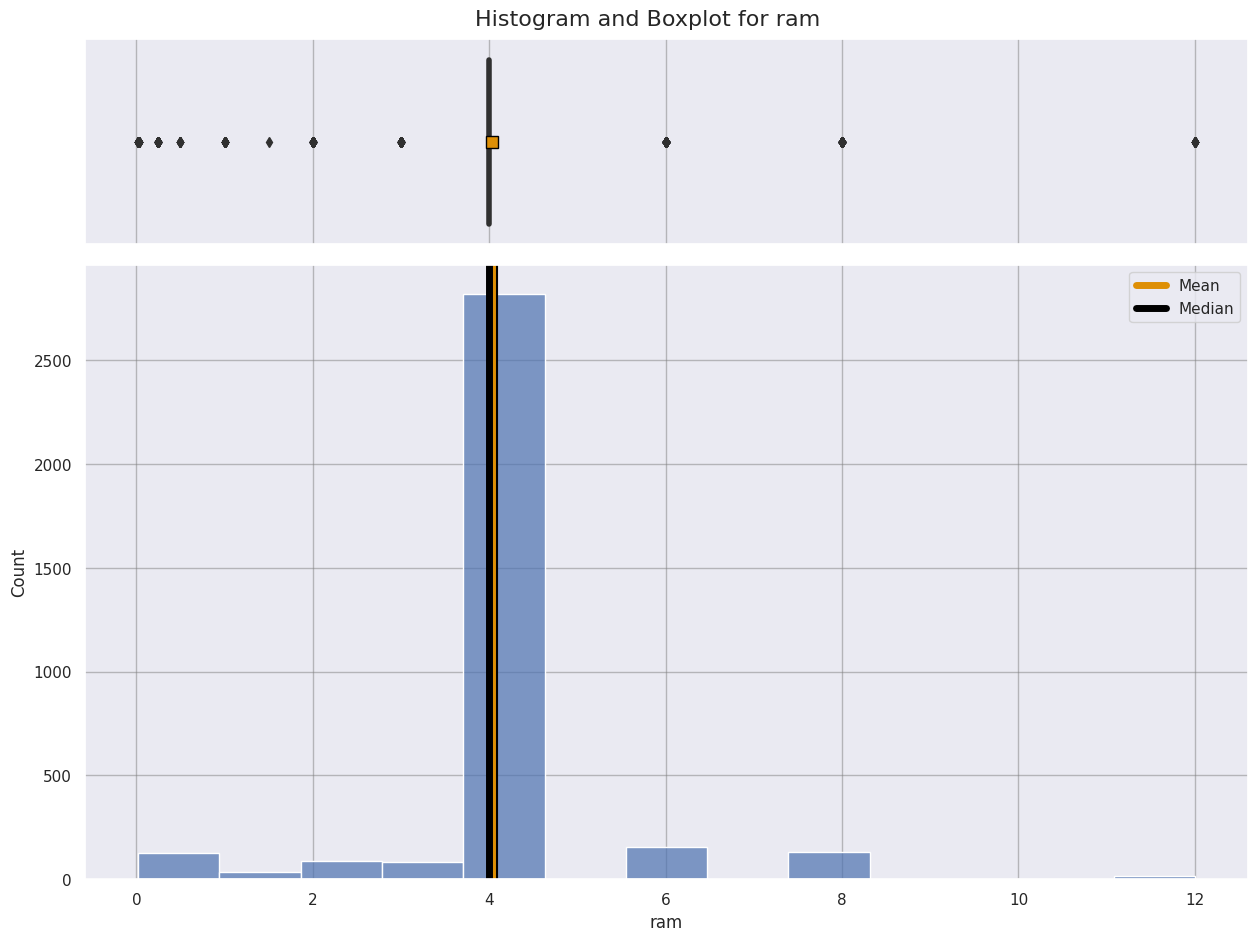

In [78]:
histogram_boxplot(df1, 'ram')

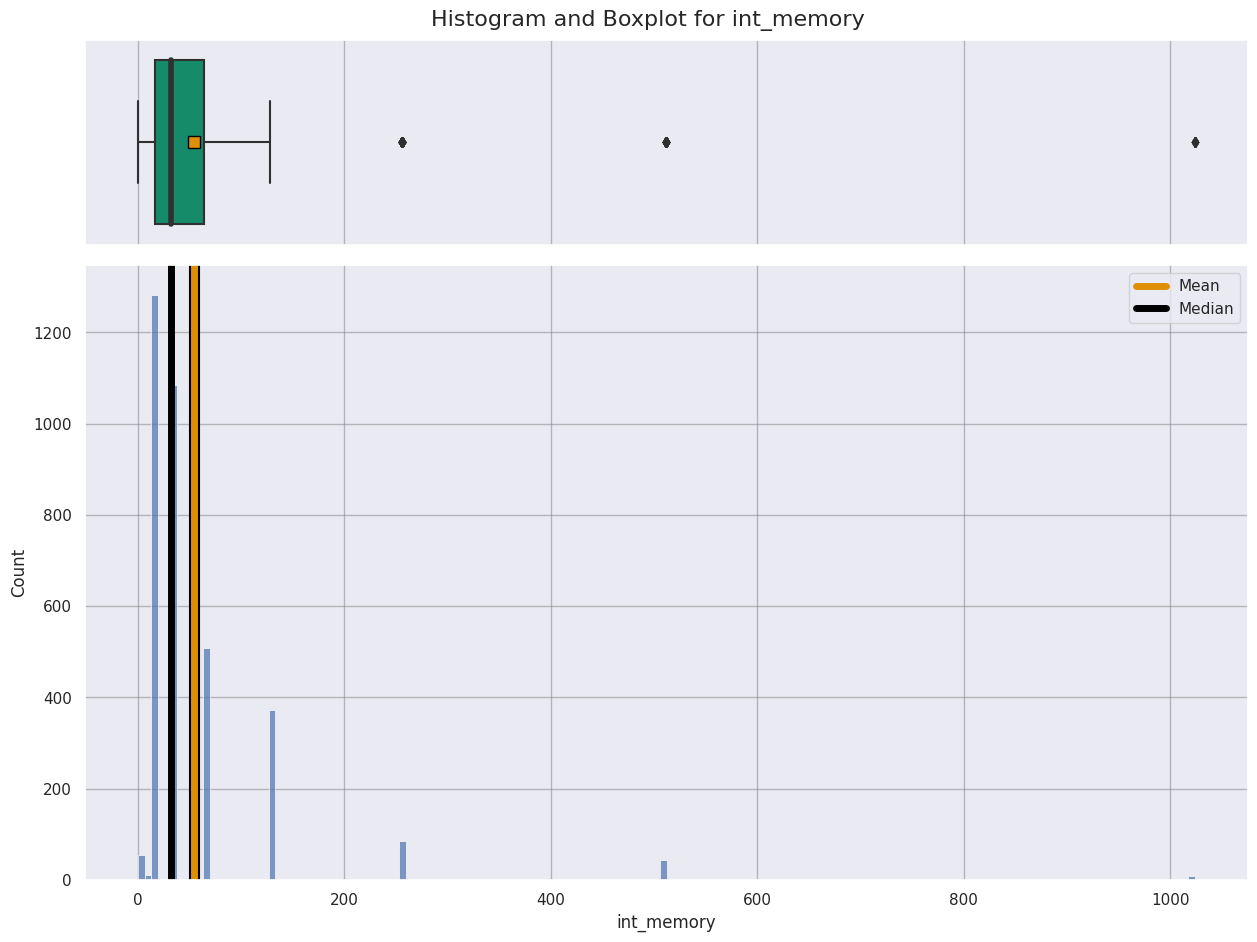

In [79]:
histogram_boxplot(df1, 'int_memory')

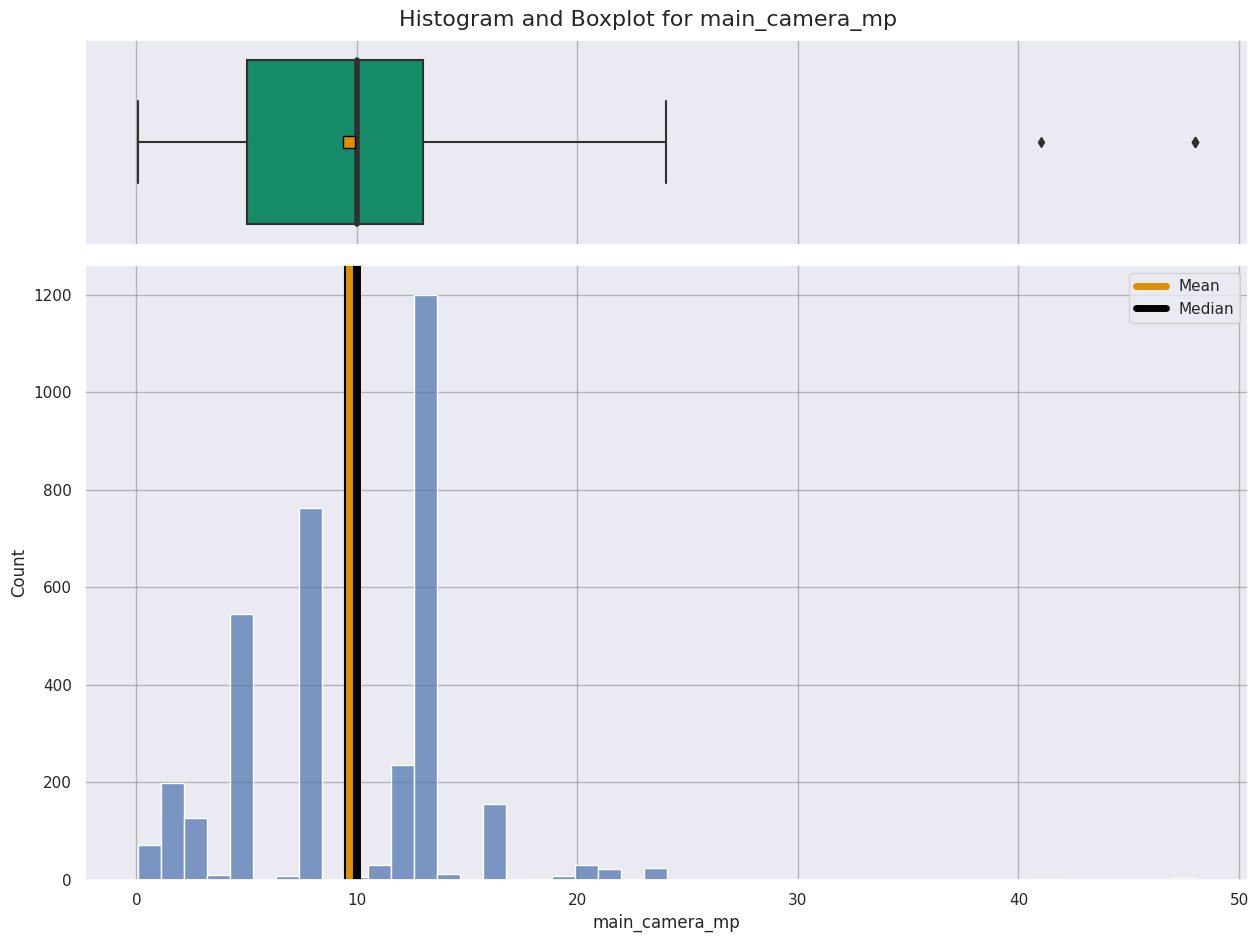

In [80]:
histogram_boxplot(df1, 'main_camera_mp')

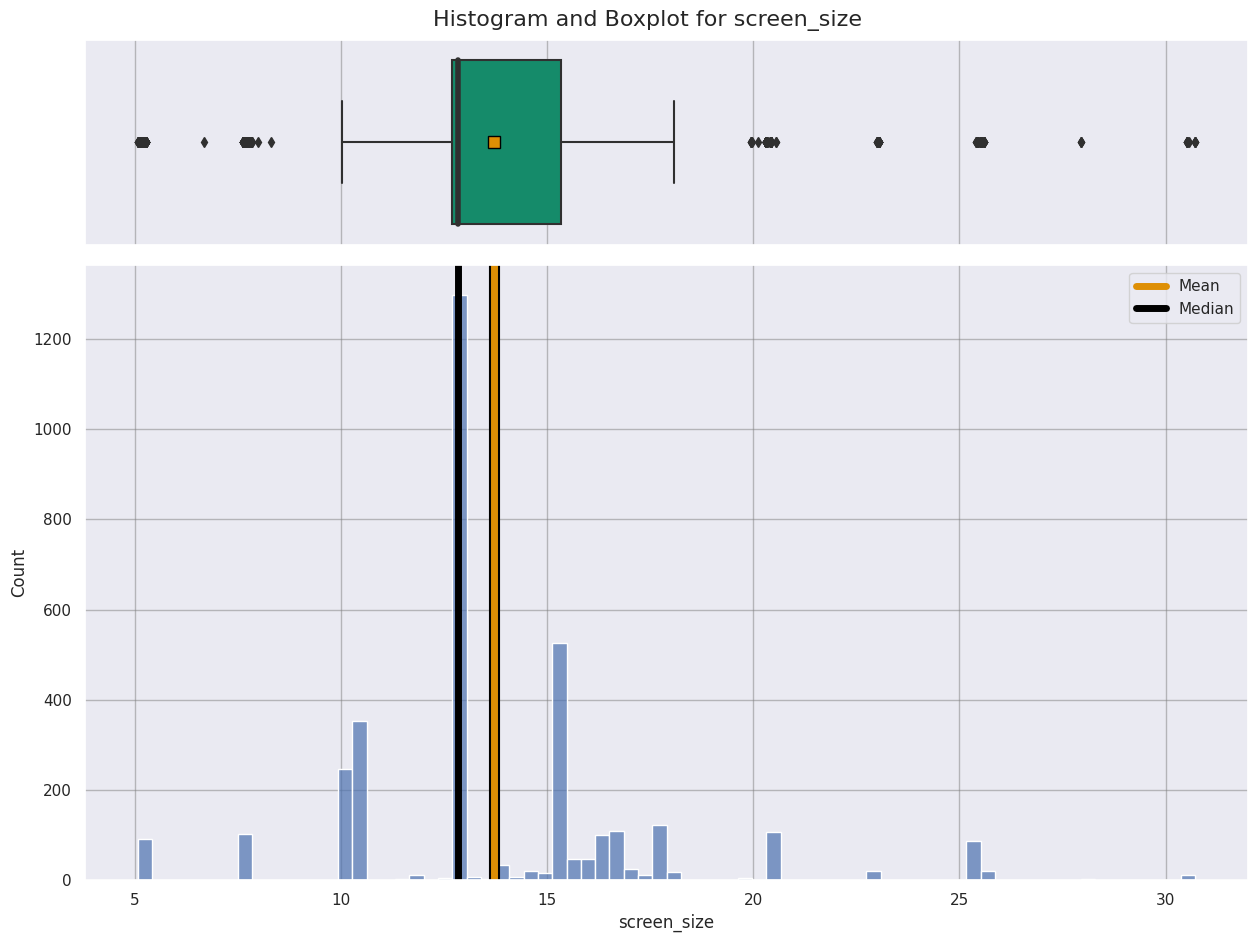

In [81]:
histogram_boxplot(df1, 'screen_size')

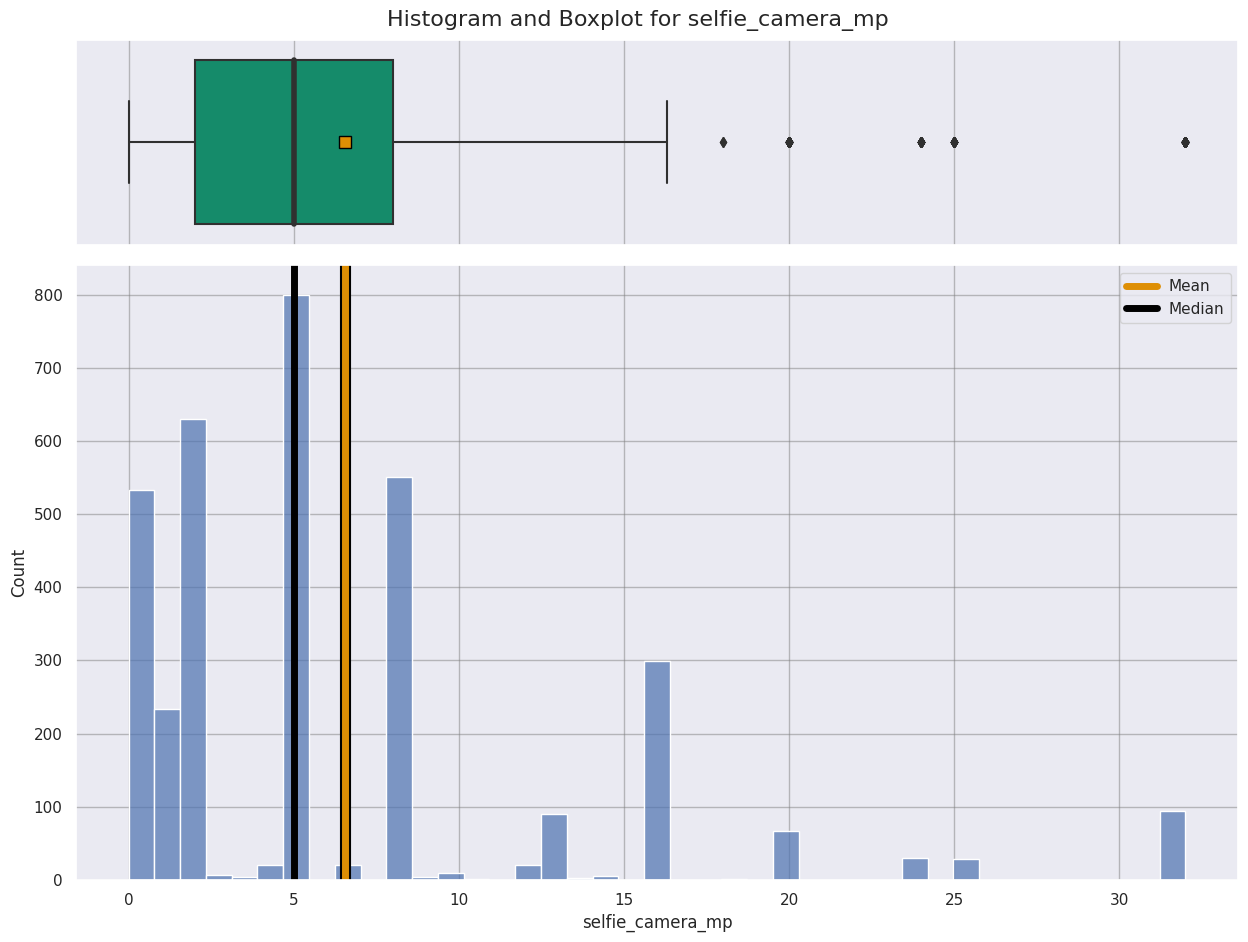

In [82]:
histogram_boxplot(df1, 'selfie_camera_mp')